In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
import os
from pathlib import Path
import seaborn as sns
import statsmodels.api as sm

# function

## dsmil results functions

In [2]:
def reader_kfold(result_dir:str,dropout=False) -> pd.DataFrame:
    results = glob.glob(f'/GPUFS/sysu_jhluo_1/wangyh/data/TCGA_bladder_threshold_80/train/training_details/{result_dir}/re*.txt')
    result_list = [pd.read_csv(i,header=None) for i in results]
    result = pd.concat(result_list)
    if dropout:
        result.columns = [
        "learning rate",
        "weight_decay",
        "Tmax",
        "dropout_patch",
        "dropout_node",
        "avg best score",
        "avg best auc",
        "best avg epoch",
        'avg_loss_score',  # best score where loss reaches its best
        'avg_loss_auc',
        'avg_loss'
        ]
    else:
        result.columns = [
        "learning rate",
        "weight_decay",
        "Tmax",
        "avg best score",
        "avg best auc",
        "best avg epoch",
        'avg_loss_score',  # best score where loss reaches its best
        'avg_loss_auc',
        'avg_loss'
        ]
    return result
        
def vis_best_metrics(results,metrics,top=5,run=None,figsize = (50, 50),output=False):
    """
    args:
        stats_df：tuple: (dataframe of result, run number)
        metrics: best auc,best score,best avg auc statistical data in different settings of hyperparameter
        top: show top N best point with stars
        run:if results are pd.DataFrame, assign run manually for correct saving of output figs. specially used in result 1-3
    """
    stats_df = results
    labels_lr = [str(i) for i in np.sort(stats_df["learning rate"].unique())]
    labels_wd = [str(i) for i in np.sort(stats_df["weight_decay"].unique())]
    labels_Tmax = [str(i) for i in np.sort(stats_df["Tmax"].unique())]
    auc_list = []
    score_list = []
    avg_auc_list = []
    # NOTE:auc/score/avg_auc_list is wrongly named, they have no relation with names but only a recorder of metrics for different hyperparameters seperately
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    for i in labels_lr:
        lr = eval(i)
        auc_list.append(stats_df[stats_df["learning rate"] == lr][metrics])
    axes[0].boxplot(auc_list, labels=labels_lr)
    axes[0].set_xlabel("learning rate")
    axes[0].xticks(rotation=45)
    axes[0].set_ylabel(metrics)
    
    for i in labels_wd:
        wd = eval(i)
        score_list.append(stats_df[stats_df["weight_decay"] == wd][metrics])
    axes[1].boxplot(score_list, labels=labels_wd)
    axes[1].set_xlabel("weight_decay")
    axes[1].set_ylabel(metrics)
    for i in labels_Tmax:
        Tmax = eval(i)
        avg_auc_list.append(stats_df[stats_df["Tmax"] == Tmax][metrics])
    axes[2].boxplot(avg_auc_list, labels=labels_Tmax)
    axes[2].set_xlabel("Tmax")
    axes[2].set_ylabel(metrics)

    print(stats_df[metrics].describe())
    
def top_comb(results,metrics,top=10):
    '''
    get hyperparameter combinations that reach top N auc/score/avg auc
    args:
        results:get from reader function
        metrics: choose from [best auc,best score,best avg auc]
        top: get top N combinations, 10 by default
    return:
        3 list containing best hyperparameter combinations ---- best_auc_comb,best_score_comb,best_avg_auc_comb
        each list is composed of a tuple:(comb:series,value of metric)
        here is an example:
            ((
            learning rate    0.000920
            weight_decay     0.000005
            Tmax             50.000000
            Name: 343, dtype: float64
            ),metric:1.2994971264367816)
    '''
    if type(results) == pd.DataFrame:
        stats_df = results
    elif type(results) == tuple:
        stats_df,_ = results
    else:
        raise TypeError('type of results should be pd.DataFrame or tuple')
    top_df = stats_df.sort_values([metrics],ascending = False).head(10)
    col_index_dict = {
        'best score':3,
        'best auc':4,
        'best avg auc':5
    }
    best_comb = [(top_df.iloc[i,:3],top_df.iloc[i,col_index_dict[metrics]]) for i in range(top)]
    return best_comb

def view_boosting(results,title,figsize=(15,30),output=False):
    '''
    resutls:get from reader function,a list of result, must be arranged in correct order
    title:choose from ['simclr','pretrained Res18','pretrained Res50']
    '''
    best_auc_list = [__extract_metrics(top_comb(result,'best auc')) for result in results]
    best_score_list = [__extract_metrics(top_comb(result,'best score')) for result in results]
    N_auc = len(best_auc_list)
    N_score = len(best_score_list)
    fig,axes = plt.subplots(1,2,figsize = figsize)
    if title:
        fig.suptitle(title)
    b0=axes[0].boxplot(best_auc_list,labels = ['trial 1','trial 2','trial 3'][:N_auc],patch_artist=True)
    for patch, color in zip(b0['boxes'], ['coral','orange','yellow'][:N_auc]):
        patch.set_facecolor(color)
    axes[0].set_title('best auc')
    
    b1=axes[1].boxplot(best_score_list,labels = ['trial 1','trial 2','trial 3'][:N_score],patch_artist=True)
    for patch, color in zip(b1['boxes'], ['coral','orange','yellow'][:N_score]):
        patch.set_facecolor(color)
    axes[1].set_title('best score')
    if output:
        save_dir = '../out/5_classifier/classifier_comparison'
        if not os.path.exists(save_dir):
            os.makedirs(save_dir,exist_ok=True)
        plt.savefig(f'../out/5_classifier/classifier_comparison/{title}.png')
    print(f'pic saved at :/out/5_classifier/classifier_comparison/{title}.png')

def __extract_metrics(top_comb):
    metrics = [i[1] for i in top_comb]
    return metrics

def vis_scatter(description,result,factor_list,metrics,figsize = (10,20),output = True):
    num = len(factor_list)
    result_df = result[0]
    run = result[1]
    fig, axes = plt.subplots(num,1,figsize=figsize)
    for i in range(num):
        axes[i].scatter(result_df[f'{factor_list[i]}'],result_df[f'{metrics}'])
        axes[i].set_xlabel(factor_list[i])
        axes[i].set_ylabel(metrics)
    if output:
        plt.savefig(f'./mil classifier/{description}_{run}/{metrics}.png')
        
def vis_lr_on_metrics(result, metrics, figsize=(40,20), save=False):
    result_df = result
    colors = []
    lr = result_df['learning rate']
    wd = result_df['weight_decay']

    # 初始化颜色映射和图例处理
    color_label_map = {
        'red': 'LR: 1e-4~1e-3',
        'blue': 'LR: 1e-5~1e-4',
        'green': 'LR: 1e-6~1e-5'
    }
    
    # 根据学习率值设定颜色
    for learning_rate in lr:
        if learning_rate >= 0.0001 and learning_rate < 0.001:
            colors.append('red')
        elif learning_rate >= 0.00001 and learning_rate < 0.0001:
            colors.append('blue')
        else:
            colors.append('green')

    # 绘制散点图
    plt.figure(figsize=figsize)
    scatter_plots = []
    for color in color_label_map:
        # 对每种颜色绘制一个空的散点图，用于图例
        scatter_plot = plt.scatter([], [], c=color, label=color_label_map[color])
        scatter_plots.append(scatter_plot)
    
    # 绘制实际的散点图，不包含label
    plt.scatter(wd, result[metrics], c=colors)
    
    # 添加图例
    plt.legend(handles=scatter_plots)

    plt.xlabel('Weight Decay')
    plt.ylabel(metrics)
    if save:
        plt.savefig(f'./model_selection/{save}.svg',format='svg')
        print('saved image')
    plt.show()
    
    
def vis_wd_on_metrics(result,metrics,figsize = (20,10),save = False):
    colors = []
    lr = result['learning rate']
    wd = result['weight_decay']
    
    color_label_map = {
        'red': 'weight_decay: 1e-4~1e-3',
        'blue': 'weight_decay: 1e-5~1e-4',
        'green': 'weight_decay: 1e-6~1e-5'
    }
    for learning_rate in wd:
        if learning_rate >= 0.0001 and learning_rate < 0.001:
            colors.append('red')
        elif learning_rate >= 0.00001 and learning_rate < 0.0001:
            colors.append('blue')
        else:
            colors.append('green')
            
    # 绘制散点图
    plt.figure(figsize=figsize)
    scatter_plots = []
    for color in color_label_map:
        # 对每种颜色绘制一个空的散点图，用于图例
        scatter_plot = plt.scatter([], [], c=color, label=color_label_map[color])
        scatter_plots.append(scatter_plot)
    
    # 绘制实际的散点图，不包含label
    plt.scatter(lr, result[metrics], c=colors)
    
    # 添加图例
    plt.legend(handles=scatter_plots)

    plt.xlabel('Learning Rate')
    plt.ylabel(metrics)
    if save:
        plt.savefig(f'./model_selection/{save}.svg',format='svg')
        print('saved image')
    plt.show()
    
def show_topK_metrics(df,k,metrics):
    top_idx = df.sort_values(f'{metrics}', ascending=False).head(k).index
    result = df.loc[top_idx,:]
    print(df[f'{metrics}'].describe())
    return result

def compare_features(metrics,df_list,name_list,figsize=(10,5),save=False):
    plt.figure(figsize=figsize)
    color_list = [
    "#007BFF", "#007BFF",  # 第一组：浅天蓝与亮蓝色  
    "#A5D6A7", "#A5D6A7",  # 第二组：浅玉绿与亮绿色 
    "#B10DC9", "#B10DC9",  # 第三组：浅紫色与亮紫色  
    "#FFA500", "#FFA500",  # 第四组：浅金色与亮橙色  
    "#00CED1", "#00CED1",  # 第五组：浅天蓝绿与亮蓝绿  |
    "#DC143C", "#DC143C",  # 第六组：浅玫瑰色与亮红色  
    "#00BFFF", "#00BFFF",  # 第七组：浅天蓝与亮青色  
    "#FF6347", "#FF6347",  # 第八组：浅玫瑰色与亮橙色  
#     "#ADD8E6", "#007BFF",  # 第一组：浅天蓝与亮蓝色  
#     "#C8E6C9", "#A5D6A7",  # 第二组：浅玉绿与亮绿色 
#     "#DDA0DD", "#B10DC9",  # 第三组：浅紫色与亮紫色  
#     "#FFD700", "#FFA500",  # 第四组：浅金色与亮橙色  
#     "#E6F7FA", "#00CED1",  # 第五组：浅天蓝绿与亮蓝绿  |
#     "#F08080", "#DC143C",  # 第六组：浅玫瑰色与亮红色  
#     "#87CEEB", "#00BFFF",  # 第七组：浅天蓝与亮青色  
#     "#FFDAB9", "#FF6347",  # 第八组：浅玫瑰色与亮橙色  
#     "#FF9999", "#FF0000",  # 红色系
#     "#99FF99", "#00FF00",  # 绿色系
#     "#9999FF", "#0000FF",  # 蓝色系
#     "#FFFF99", "#FFFF00",  # 黄色系
#     "#FF99FF", "#FF00FF",  # 紫色系
#     "#99FFFF", "#00FFFF",  # 青色系
#     "#FFCC99", "#FF9900",  # 橙色系
#     "#CCCCCC", "#555555",  # 灰色系
    ]  
    for df,name,color,line in zip(df_list,name_list,color_list[:len(df_list)],['-','--']*6):
        Y_coords = np.sort(np.array(df[metrics]))
        X_coords = np.linspace(0, 1, len(Y_coords)) 
        print(f'{name} has {len(Y_coords)} data points')
        try:
            plt.plot(X_coords,Y_coords,label=name,color=color,linestyle=line)
        except Exception as e:
            print(f'{name} error:{e}')
    plt.legend()
    if save:
        plt.savefig(f'./model_selection/{save}.svg',format='svg')
        print('saved image')
    plt.show()


def compare_features_box(metrics,df_list,name_list,figsize=(20, 10),save=False):
    # 将每个条件下的所有实验结果的数据点表示放在一列展示，绘制箱型图
    plt.figure(figsize=figsize)
    color_list = [
    "#FF9999", "#FF0000",  # 红色系
    "#99FF99", "#00FF00",  # 绿色系
    "#9999FF", "#0000FF",  # 蓝色系
    "#FFFF99", "#FFFF00",  # 黄色系
    "#FF99FF", "#FF00FF",  # 紫色系
    "#99FFFF", "#00FFFF",  # 青色系
    "#FFCC99", "#FF9900",  # 橙色系
    "#CCCCCC", "#555555",  # 灰色系
    ]
    data = []
    names = []
    for df,name in zip(df_list,name_list):
        data.append(df[metrics])
        names.append(name)
    bp = plt.boxplot(data,labels=names,patch_artist=True)
    for patch,color in zip(bp['boxes'], color_list[:len(df_list)]):  
        patch.set_facecolor(color)  
        patch.set_edgecolor(color)  # 设置边框颜色为黑色  
    plt.xticks(rotation=45)
    if save:
        plt.savefig(f'./model_selection/{save}.svg',format='svg')
        print('saved image')
    plt.show()
    
def compare_features_med(metrics,stats,x_label,df_lists,name_list,save=False):
    #这里使用正负柱状图进行对比，故df_lists包含两个list，10X和20X，name_list同样
    # stats:[mean, median]
    plt.figure(figsize=(15, 5))
    data = [[],[]]
    print(data[0])
    for i,df_list in enumerate(df_lists):
        print(i)
        for df in df_list:
            if stats == 'median':
                data[i].append(df[metrics].median())
            if stats == 'mean':
                data[i].append(df[metrics].mean())
    plt.barh(name_list,data[0],color=['#72B063'],height=0.3,label='10X')
    plt.barh(name_list,-np.array(data[1]),color=['#EEB479'],height=0.3,label='20X')
    
    plt.xlim(-1,1)
    plt.xlabel(x_label)
    plt.ylabel('feature extractor')
    plt.legend()
    if save:
        plt.savefig(f'./model_selection/{save}.svg',format='svg')
        print('saved image')
    plt.show()
    
def compare_features_med_vertical(metrics,stats,x_label,df_lists,name_list,save=False):
    #这里使用正负柱状图进行对比，故df_lists包含两个list，10X和20X，name_list同样
    # stats:[mean, median]
    plt.figure(figsize=(15, 5))
    data = [[],[]]
    print(data[0])
    width = 0.35  # 条形图的宽度
    x = np.arange(len(name_list))  # 标签的位置
    for i,df_list in enumerate(df_lists):
        print(i)
        for df in df_list:
            if stats == 'median':
                data[i].append(df[metrics].median())
            if stats == 'mean':
                data[i].append(df[metrics].mean())
    plt.bar(x - width/2, data[0], width, color='#72B063', label='10X')
    plt.bar(x + width/2, data[1], width, color='#EEB479', label='20X')
    
    plt.ylabel(x_label)
    plt.xlabel('Feature Extractor')
    plt.xticks(ticks=x, labels=name_list,rotation=45)  # 设置x轴刻度标签
    plt.ylim(0, 0.9)  # 设置y轴的限制
    plt.legend()
    if save:
        plt.savefig(f'./model_selection/{save}.svg',format='svg')
        print('saved image')
    plt.show()

def compare_features_table(metrics,df_list,name_list):
    pass
    
def compare_Tmax(df, metrics,save=False):
    # 设置图形尺寸
    plt.figure(figsize=(10, 5))
    
    X = df[['Tmax']]  # predictor
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    Y = df[metrics]  # response
    linear_regression_model = sm.OLS(Y, X).fit()
    
    # 获取回归系数
    slope = linear_regression_model.params['Tmax']
    intercept = linear_regression_model.params['const']
    
    # 使用seaborn的regplot绘制散点图和回归线
    # regplot自动计算并绘制回归线
    s = sns.regplot(x='Tmax', y=metrics, data=df, scatter_kws={'s': 50})
    
    # 设置x轴刻度标签
    # 如果Tmax是数字类型，此步骤可能不需要
    s.set_xticklabels(s.get_xticklabels())

    # 设置坐标轴标签和标题
    s.set_xlabel('Tmax')
    s.set_ylabel(metrics)
#     s.set_title(f'Relationship between Tmax and {metrics}')
    results_text = f'Slope: {slope:.2f}\nR-squared: {linear_regression_model.rsquared:.2f}'
    plt.text(0.8, 0.95, results_text, transform=s.transAxes,
             fontsize=10, verticalalignment='top',bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    if save:
        plt.savefig(f'./model_selection/{save}.svg',format='svg')
        print('saved image')
    # 显示图形
    plt.show()
    

## function for test of normality and homogeneity of variance

In [20]:
import scipy.stats as stats
from statsmodels.stats.diagnostic import lilliefors

def normality_test_SW(data):
    stat, p = stats.shapiro(data)
    print(f"Shapiro-Wilk: p = {p:.4f}")
    
def normality_test_KS(data):
    stat, p = lilliefors(data)
    print(f"Lilliefors 检验统计量: {stat:.4f}")
    print(f"p 值: {p:.4f}")
 
def qq_plot(data,save=False):
    stats.probplot(data, dist="norm", plot=plt)
    plt.show()
    
def hov_test_Levene(data1,data2):
    _, p_levene = stats.levene(data1, data2)
    print(f"Levene's test: p = {p_levene:.4f}")

## CLAM result function

In [ ]:
def process_try(folder):
    avg_values = {}
    info = folder.split('_')
    avg_values['scale'] = info[1]
    if info[2] != 'retccl':
        avg_values['extractor'] = info[2] + '_' + info[3]
        if len(info) >= 5:
            avg_values['details'] = '_'.join(info[4:-1])
    else:
        avg_values['extractor'] = info[2] + '_' + info[3] + '_' + info[4]
        if len(info) >= 6:
            avg_values['details'] = '_'.join(info[5:-1])
    avg_values['seed'] = info[-1]
    return avg_values

def process_exp(folder):
    avg_values = {}
    info = folder.split('_')
    avg_values['scale'] = info[0]
    if info[1] not in  ['retccl','simclr']:
        avg_values['extractor'] = info[1] + '_' + info[2]
        avg_values['lr'] = info[4]
        avg_values['k'] = info[5][1]
        avg_values['explore'] = info[6][7:]
        avg_values['RuleLogits'] = info[7][10:]
        if len(info) >= 9:
            avg_values['details'] = '_'.join(info[8:-1])
            if avg_values['details'].startswith('lr'):
                avg_values['details'] = ''
    else:
        avg_values['extractor'] = info[1] + '_' + info[2] + '_' + info[3]
        avg_values['lr'] = info[5]
        avg_values['k'] = info[6][1]
        avg_values['explore'] = info[7][7:]
        avg_values['RuleLogits'] = info[8][10:]
        if len(info) >= 10:
            avg_values['details'] = '_'.join(info[9:-1])
            if avg_values['details'].startswith('lr'):
                avg_values['details'] = ''

    avg_values['seed'] = info[-1]
    return avg_values

base_path = '/GPUFS/sysu_jhluo_1/wangyh/project/BLCA_TMB/processing/CLAM-master/results/'

all_data_list = []

# 遍历result文件夹下的所有子文件夹
for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    
    # 如果是子文件夹
    if os.path.isdir(folder_path):
        file_path = os.path.join(folder_path, 'summary.csv')
        
        # 检查文件是否存在
        if os.path.exists(file_path):
            
            if folder.startswith('try'):
                exp_info = process_try(folder)
            else:
                exp_info = process_exp(folder)
            # 读取CSV文件
            df = pd.read_csv(file_path,index_col=0).iloc[:,1:]
            
            # 计算平均值
            avg_values = df.mean().to_dict()
            all_data = {**exp_info,**avg_values}
            all_data_list.append(all_data)

# 整合所有数据
result_df = pd.DataFrame(all_data_list)

# 查看结果
print(result_df.head())

# 对比feature extractor

In [5]:
pretrained_resnet18_10X = reader_kfold('10X_5fold_pretrained_resnet18')
pretrained_resnet50_10X = reader_kfold('10X_5fold_pretrained_resnet50')
c16_high_10X = reader_kfold('10X_5fold_c16_high')
cTransPath_10X = reader_kfold('10X_5fold_cTransPath')
retccl_10X = reader_kfold('10X_5fold_retccl')
TCGA_high_10X = reader_kfold('10X_5fold_TCGA_high')
TCGA_low_10X = reader_kfold('10X_5fold_TCGA_low')
simclr_10X = reader_kfold('10X_5fold_simclr_scratch')

pretrained_resnet18_20X = reader_kfold('20X_5fold_pretrained_resnet18')
pretrained_resnet50_20X = reader_kfold('20X_5fold_pretrained_resnet50')
c16_high_20X = reader_kfold('20X_5fold_c16_high')
cTransPath_20X = reader_kfold('20X_5fold_cTransPath')
retccl_20X = reader_kfold('20X_5fold_retccl')
TCGA_high_20X = reader_kfold('20X_5fold_TCGA_high')
TCGA_low_20X = reader_kfold('20X_5fold_TCGA_low')
simclr_20X = reader_kfold('20X_5fold_simclr_scratch')
# show_topK_metrics(pretrained_resnet18_10X,10,'avg best auc')

## 正态性及方差齐性

In [23]:
normality_test_KS(c16_high_10X['avg_loss_auc']) 

Lilliefors 检验统计量: 0.1561
p 值: 0.0010


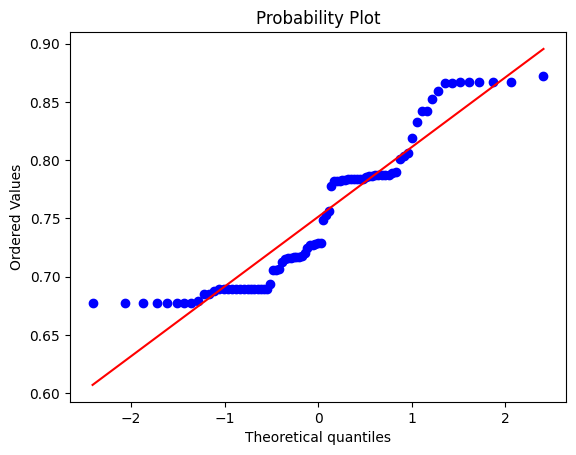

In [24]:
qq_plot(c16_high_10X['avg_loss_auc'])

## 统计分析

In [7]:
retccl_20X['avg_loss_auc'].mean()

0.5119062492661046

In [15]:
anova([pretrained_resnet18_10X,pretrained_resnet50_10X,c16_high_10X,cTransPath_10X,retccl_10X,TCGA_high_10X,TCGA_low_10X,simclr_10X],'avg_loss_auc',save='dsmil_fe_anova_10')
anova([pretrained_resnet18_20X,pretrained_resnet50_20X,c16_high_20X,cTransPath_20X,retccl_20X,TCGA_high_20X,TCGA_low_20X,simclr_20X],'avg_loss_auc',save='dsmil_fe_anova_20')

In [46]:
Kruskal_Wallis_H([pretrained_resnet18_10X,pretrained_resnet50_10X,c16_high_10X,cTransPath_10X,retccl_10X,TCGA_high_10X,TCGA_low_10X,simclr_10X],'avg_loss_auc',save='dsmil_fe_10')
Kruskal_Wallis_H([pretrained_resnet18_20X,pretrained_resnet50_20X,c16_high_20X,cTransPath_20X,retccl_20X,TCGA_high_20X,TCGA_low_20X,simclr_20X],'avg_loss_auc',save='dsmil_fe_20')

In [43]:
show_topK_metrics(c16_high_10X,10,'avg best auc')

count    82.000000
mean      0.768064
std       0.049743
min       0.717917
25%       0.726250
50%       0.734792
75%       0.806562
max       0.873750
Name: avg best auc, dtype: float64


,learning rate,weight_decay,Tmax,avg best score,avg best auc,best avg epoch,avg_loss_score,avg_loss_auc,avg_loss
34,0.000348,0.000006,75,1.274928,0.873750,46.2,1.237241,0.872083,0.394423
29,0.000348,0.000003,75,1.272658,0.867500,40.6,1.243951,0.865833,0.396058
26,0.000348,0.000006,75,1.270761,0.867083,40.6,1.244368,0.867083,0.400104
66,0.000348,0.000030,75,1.257593,0.867083,40.6,1.219871,0.867083,0.399305
65,0.000348,0.000055,75,1.241846,0.866250,40.6,1.213053,0.866250,0.401187
32,0.000348,0.000124,75,1.231092,0.863750,40.8,1.172701,0.859583,0.405184
62,0.000348,0.000013,75,1.236760,0.858750,40.6,1.191573,0.852083,0.405138
81,0.000348,0.000030,75,1.216825,0.851667,25.4,1.146214,0.842500,0.403246
15,0.000675,0.000003,75,1.172967,0.848750,25.6,1.126652,0.832500,0.415886
14,0.000675,0.000013,75,1.178822,0.840417,25.6,1.066379,0.803750,0.423940


pretrained_resnet18_10X has 81 data points
pretrained_resnet18_20X has 81 data points
pretrained_resnet50_10X has 81 data points
pretrained_resnet50_20X has 81 data points
cTransPath_10X has 81 data points
cTransPath_20X has 81 data points
retccl_10X has 81 data points
retccl_20X has 79 data points
c16_high_10X has 87 data points
c16_high_20X has 81 data points
TCGA_high_10X has 81 data points
TCGA_high_20X has 81 data points


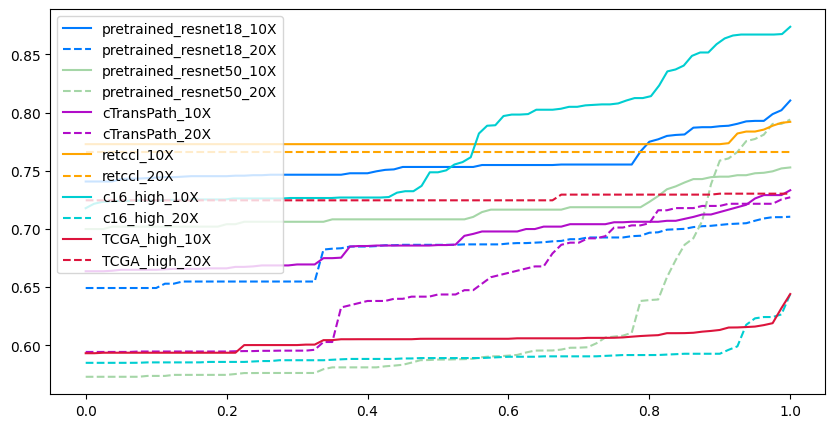

In [11]:
df_list_line = [pretrained_resnet18_10X,pretrained_resnet18_20X,pretrained_resnet50_10X,pretrained_resnet50_20X,cTransPath_10X,cTransPath_20X,retccl_10X,retccl_20X,c16_high_10X,c16_high_20X,TCGA_high_10X,TCGA_high_20X,TCGA_low_10X,TCGA_low_20X,simclr_10X,simclr_20X]
name_list_line = ['pretrained_resnet18_10X','pretrained_resnet18_20X','pretrained_resnet50_10X','pretrained_resnet50_20X','cTransPath_10X','cTransPath_20X','retccl_10X','retccl_20X','c16_high_10X','c16_high_20X','TCGA_high_10X','TCGA_high_20X','TCGA_low_10X','TCGA_low_20X','simclr_10X','simclr_20X']
compare_features('avg best auc',df_list_line,name_list_line)

pretrained_resnet18_10X has 81 data points
pretrained_resnet18_20X has 81 data points
pretrained_resnet50_10X has 81 data points
pretrained_resnet50_20X has 81 data points
cTransPath_10X has 81 data points
cTransPath_20X has 81 data points
retccl_10X has 81 data points
retccl_20X has 79 data points
c16_high_10X has 87 data points
c16_high_20X has 81 data points
TCGA_high_10X has 81 data points
TCGA_high_20X has 81 data points


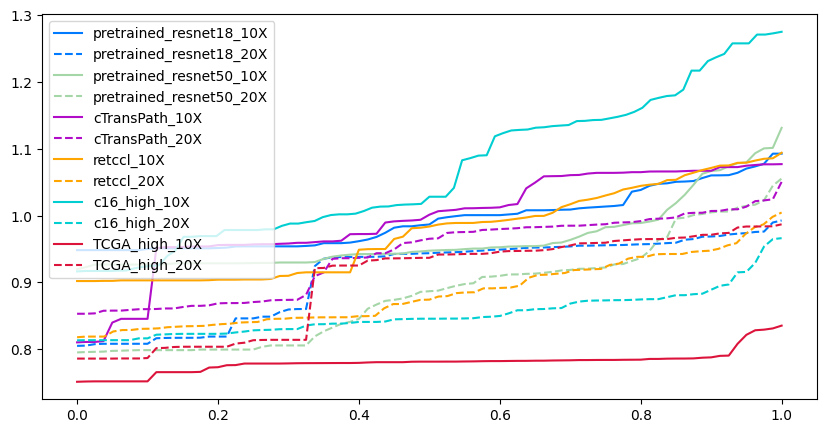

In [13]:
compare_features('avg best score',df_list_line,name_list_line)

pretrained_resnet18_10X has 81 data points
pretrained_resnet18_20X has 81 data points
pretrained_resnet50_10X has 81 data points
pretrained_resnet50_20X has 81 data points
cTransPath_10X has 81 data points
cTransPath_20X has 81 data points
retccl_10X has 81 data points
retccl_20X has 79 data points
c16_high_10X has 87 data points
c16_high_20X has 81 data points
TCGA_high_10X has 81 data points
TCGA_high_20X has 81 data points
saved image


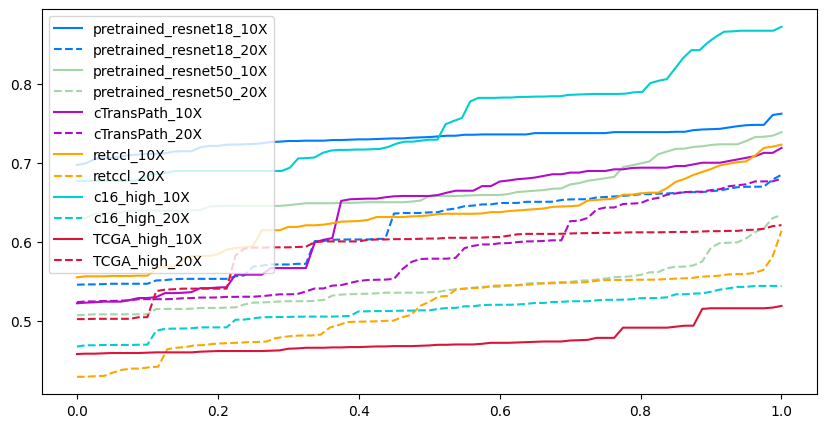

In [14]:
compare_features('avg_loss_auc',df_list_line,name_list_line,save='compare_features_line')

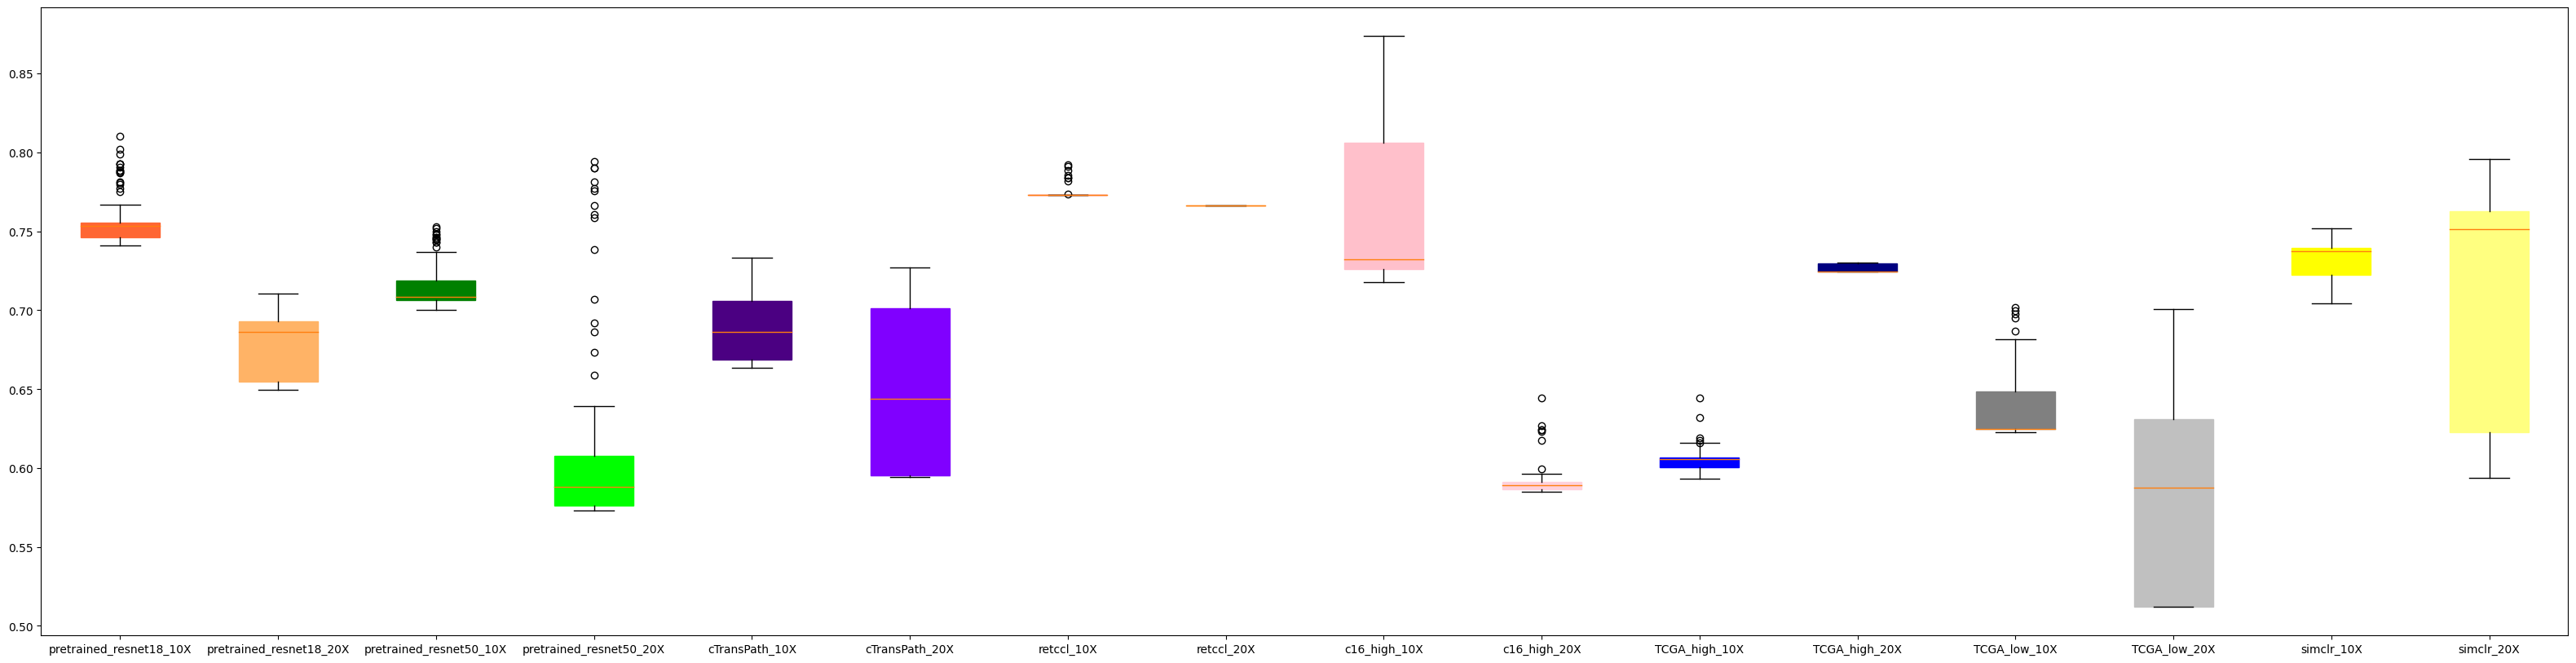

In [435]:
compare_features_box('avg best auc',df_list_line,name_list_line)

saved image


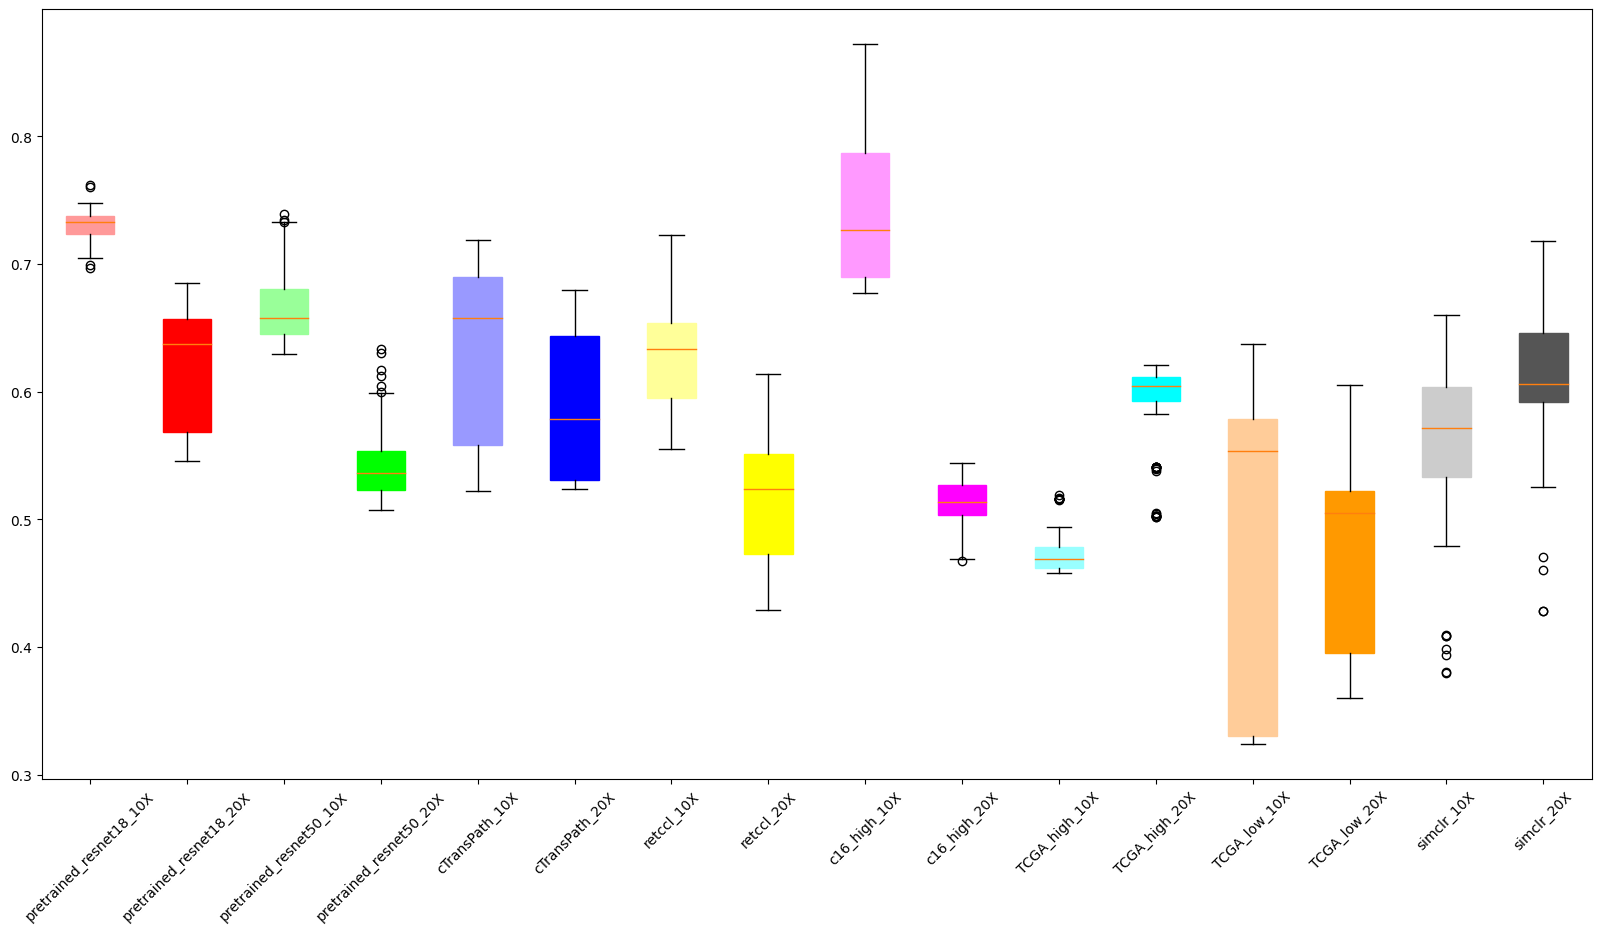

In [32]:
compare_features_box('avg_loss_auc',df_list_line,name_list_line,
                     save='compare_features_box'
                    )

[]
0
1


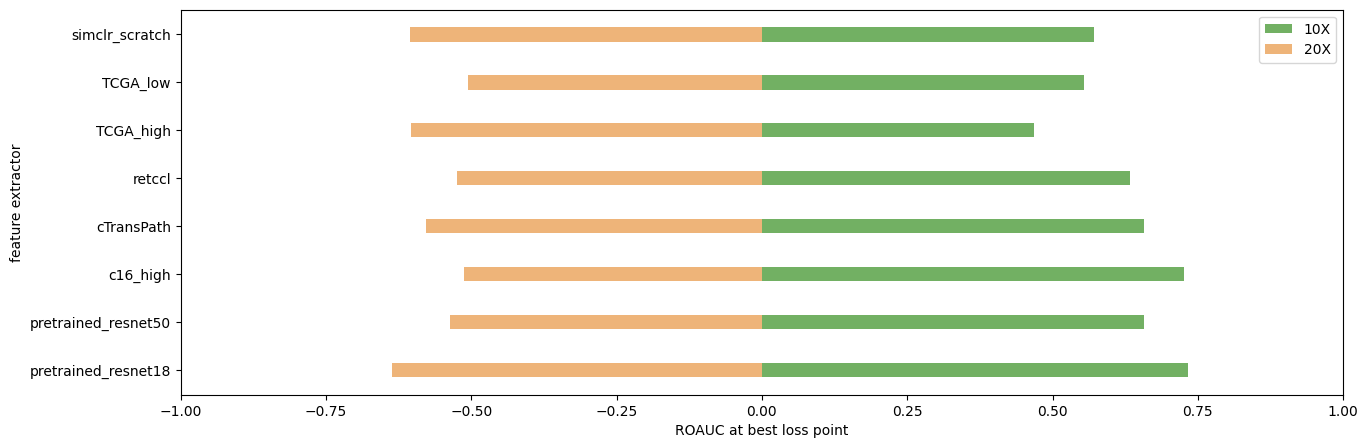

In [243]:
df_lists=[
    [pretrained_resnet18_10X,pretrained_resnet50_10X,c16_high_10X,cTransPath_10X,retccl_10X,TCGA_high_10X,TCGA_low_10X,simclr_10X],
    [pretrained_resnet18_20X,pretrained_resnet50_20X,c16_high_20X,cTransPath_20X,retccl_20X,TCGA_high_20X,TCGA_low_20X,simclr_20X]
]
name_list = ['pretrained_resnet18','pretrained_resnet50','c16_high','cTransPath','retccl','TCGA_high','TCGA_low','simclr_scratch']
compare_features_med('avg_loss_auc','median','ROAUC at best loss point',df_lists,name_list)

# 对比scale

[]
0
1
saved image


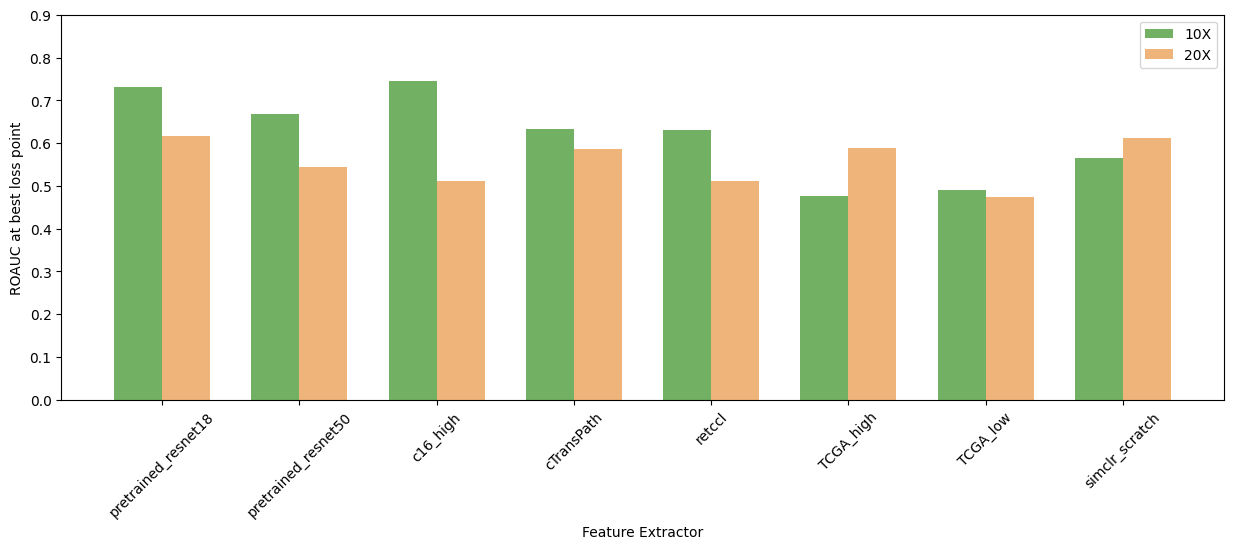

In [445]:
compare_features_med_vertical('avg_loss_auc','mean','ROAUC at best loss point',df_lists,name_list,save='compare_scale_DSMIL_auc_mean')

[]
0
1
saved image


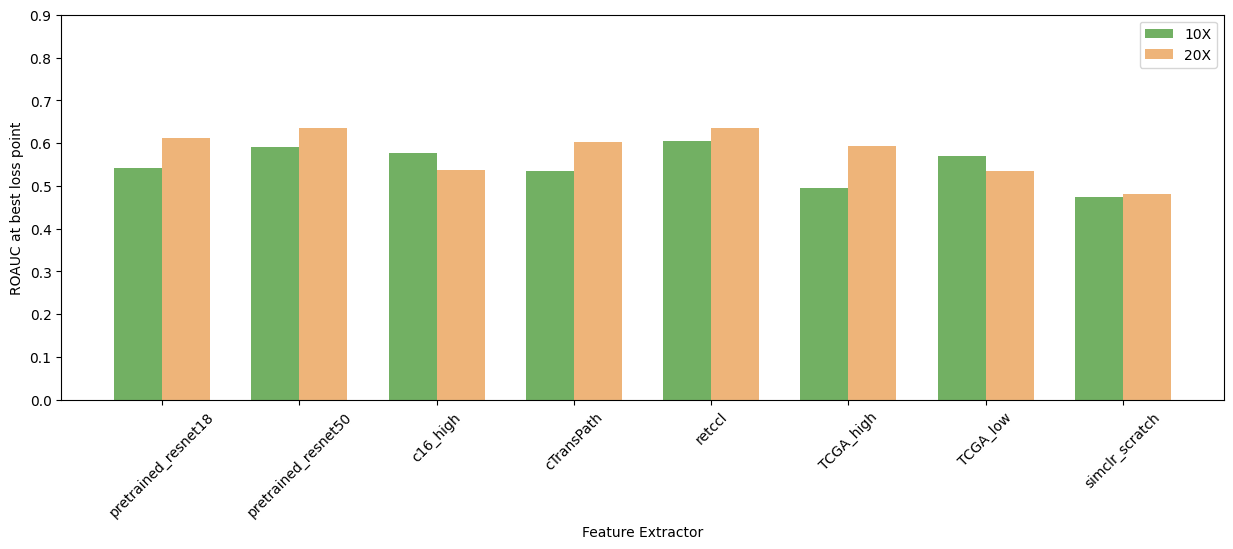

In [463]:
df_lists_CLAM = [
    [CLAM_PtRes18_10X,CLAM_PtRes50_10X,CLAM_c16_10X,CLAM_cTransPath_10X,CLAM_retccl_10X,CLAM_TCGA_high_10X,CLAM_TCGA_low_10X,CLAM_simclr_10X],
    [CLAM_PtRes18_20X,CLAM_PtRes50_20X,CLAM_c16_20X,CLAM_cTransPath_20X,CLAM_retccl_20X,CLAM_TCGA_high_20X,CLAM_TCGA_low_20X,CLAM_simclr_20X]
]
compare_features_med_vertical('val_auc','mean','ROAUC at best loss point',df_lists_CLAM,name_list,save='compare_scale_CLAM_auc_mean')

In [467]:
t_test(df_lists,name_list,metrics_list=['avg_loss_auc','avg_loss_auc'],save='compare_scale_10_ttest')
t_test(df_lists_CLAM,name_list,metrics_list=['val_auc','val_auc'],save='compare_scale_20_ttest')

# 对比lr & weight decay

In [469]:
c16_high_10X

,learning rate,weight_decay,Tmax,avg best score,avg best auc,best avg epoch,avg_loss_score,avg_loss_auc,avg_loss
0,0.000002,0.000055,75,0.924533,0.726250,74.0,0.857938,0.677083,0.488892
1,0.000002,0.000124,75,0.925575,0.726250,74.0,0.874138,0.677083,0.488847
2,0.000002,0.000013,75,0.917069,0.726250,74.0,0.856897,0.677083,0.488919
3,0.000005,0.000013,75,0.968211,0.726667,74.0,0.882471,0.689583,0.471933
4,0.000002,0.000006,75,0.917069,0.726250,74.0,0.856897,0.677083,0.488922
...,...,...,...,...,...,...,...,...,...
76,0.000009,0.000279,75,0.988003,0.725417,74.0,0.988003,0.685417,0.462444
77,0.000009,0.000685,75,0.984591,0.724167,74.0,0.979382,0.685417,0.462449
78,0.000009,0.000055,75,0.979382,0.725417,74.0,0.979382,0.689583,0.462230
79,0.000009,0.000003,75,0.978341,0.727083,74.0,0.978341,0.689583,0.462152


saved image


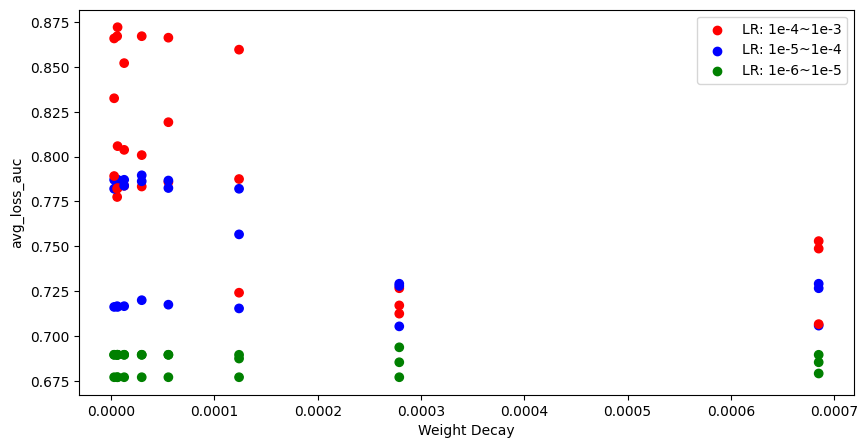

In [508]:
vis_lr_on_metrics(c16_high_10X, metrics='avg_loss_auc',figsize = (10,5),save='compare_lr')

saved image


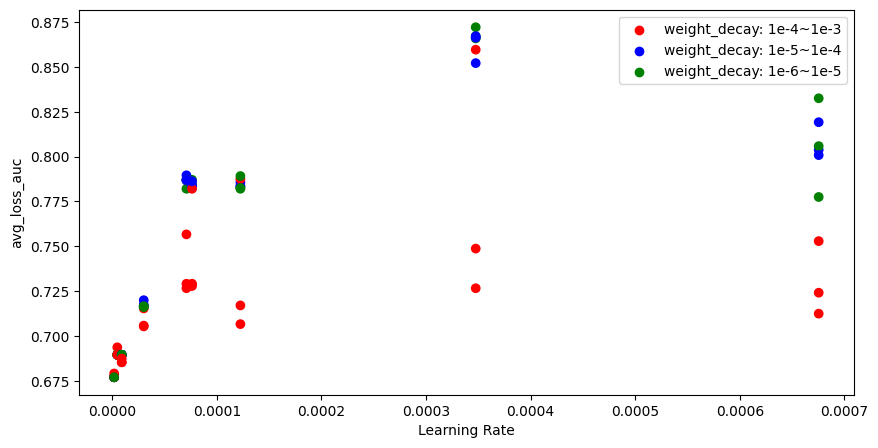

In [511]:
vis_wd_on_metrics(c16_high_10X, metrics='avg_loss_auc',figsize = (10,5),save='compare_weightdecay')

In [514]:
show_topK_metrics(c16_high_10X,metrics='avg_loss_auc',k=10)

count    81.000000
mean      0.744244
std       0.057879
min       0.677083
25%       0.689583
50%       0.726667
75%       0.786250
max       0.872083
Name: avg_loss_auc, dtype: float64


,learning rate,weight_decay,Tmax,avg best score,avg best auc,best avg epoch,avg_loss_score,avg_loss_auc,avg_loss
34,0.000348,0.000006,75,1.274928,0.873750,46.2,1.237241,0.872083,0.394423
66,0.000348,0.000030,75,1.257593,0.867083,40.6,1.219871,0.867083,0.399305
26,0.000348,0.000006,75,1.270761,0.867083,40.6,1.244368,0.867083,0.400104
65,0.000348,0.000055,75,1.241846,0.866250,40.6,1.213053,0.866250,0.401187
29,0.000348,0.000003,75,1.272658,0.867500,40.6,1.243951,0.865833,0.396058
32,0.000348,0.000124,75,1.231092,0.863750,40.8,1.172701,0.859583,0.405184
62,0.000348,0.000013,75,1.236760,0.858750,40.6,1.191573,0.852083,0.405138
15,0.000675,0.000003,75,1.172967,0.848750,25.6,1.126652,0.832500,0.415886
13,0.000675,0.000055,75,1.179856,0.823333,23.2,1.179856,0.819167,0.422056
16,0.000675,0.000006,75,1.188391,0.835417,15.2,1.084928,0.805833,0.425182


# 对比Tmax

In [518]:
Tmax_pretrained_resnet18_10X = reader_kfold('10X_5fold_pretrained_resnet18_TmaxSelection')

/tmp/ipykernel_120379/1891070456.py:375: UserWarning: FixedFormatter should only be used together with FixedLocator
  s.set_xticklabels(s.get_xticklabels())


saved image


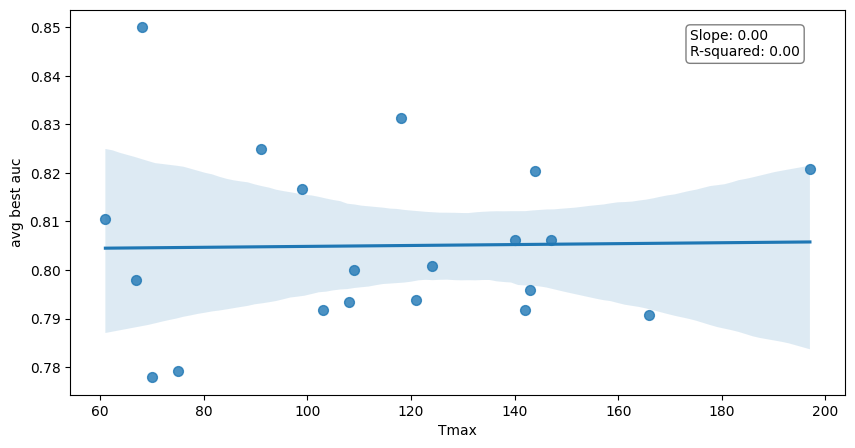

In [543]:
compare_Tmax(Tmax_pretrained_resnet18_10X,'avg best auc',save='Tmax')

# 对比reg

In [34]:
reg1_c16_high_10X = reader_kfold('10X_5fold_c16_high_reg1')
reg2_c16_high_10X = reader_kfold('10X_5fold_c16_high_reg2')
reg3_c16_high_10X = reader_kfold('10X_5fold_c16_high_reg3')
reg4_c16_high_10X = reader_kfold('10X_5fold_c16_high_reg4')

c16_high_10X has 82 data points
reg1_c16_high_10X has 81 data points
reg2_c16_high_10X has 81 data points
reg3_c16_high_10X has 81 data points
reg4_c16_high_10X has 81 data points
saved image


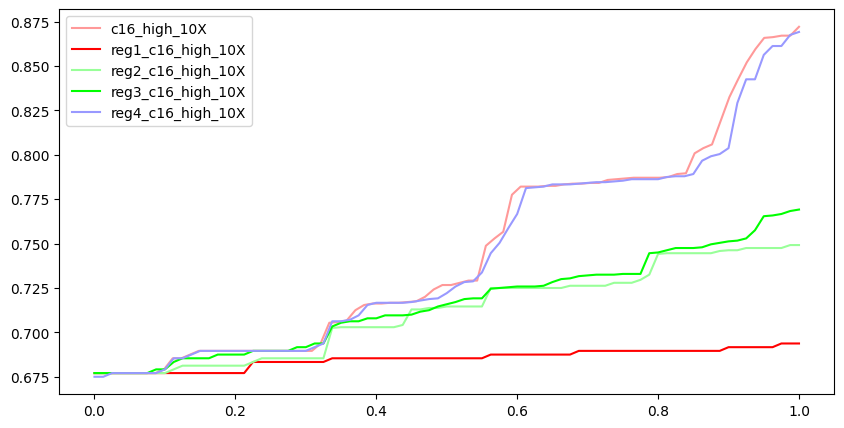

In [35]:
compare_features('avg_loss_auc',[c16_high_10X,reg1_c16_high_10X,reg2_c16_high_10X,reg3_c16_high_10X,reg4_c16_high_10X],['c16_high_10X','reg1_c16_high_10X','reg2_c16_high_10X','reg3_c16_high_10X','reg4_c16_high_10X'],save='compare_reg')

# 对比 dropout

In [40]:
dropout_c16_high_10X = reader_kfold('10X_5fold_c16_high_dropout_node',dropout=True)

c16_high_10X has 82 data points
dropout_c16_high_10X has 144 data points
saved image


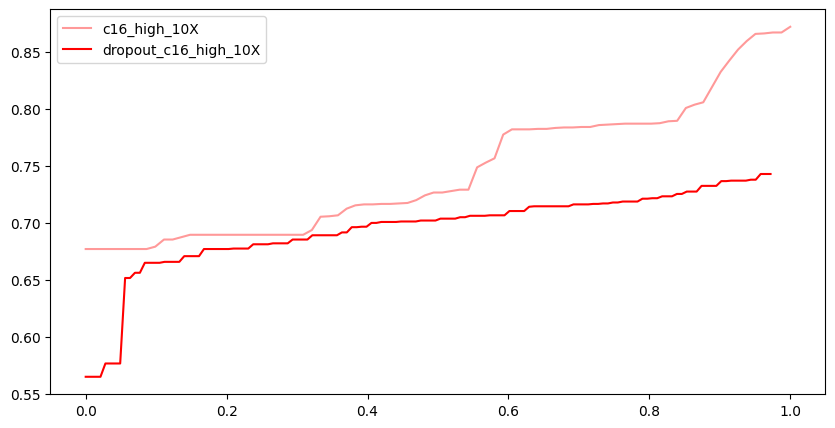

In [41]:
compare_features('avg_loss_auc',[c16_high_10X,dropout_c16_high_10X],['c16_high_10X','dropout_c16_high_10X'],save='compare_dropout')

# 对比schedule\warmup

In [37]:
Nosched_c16_high_10X = reader_kfold('10X_5fold_c16_high_NoSched')
Nowarmup_c16_high_10X = reader_kfold('10X_5fold_c16_high_warmup')

c16_high_10X has 81 data points
Nosched_c16_high_10X has 81 data points
Nowarmup_c16_high_10X has 81 data points
saved image


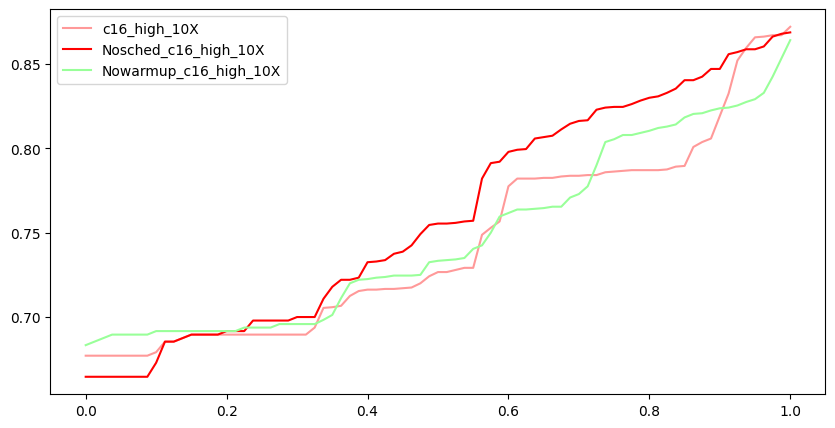

In [544]:
compare_features('avg_loss_auc',[c16_high_10X,Nosched_c16_high_10X,Nowarmup_c16_high_10X],['c16_high_10X','Nosched_c16_high_10X','Nowarmup_c16_high_10X'],save='compare_sched_warmup')

c16_high_10X has 82 data points
Nosched_c16_high_10X has 81 data points
Nowarmup_c16_high_10X has 81 data points
saved image


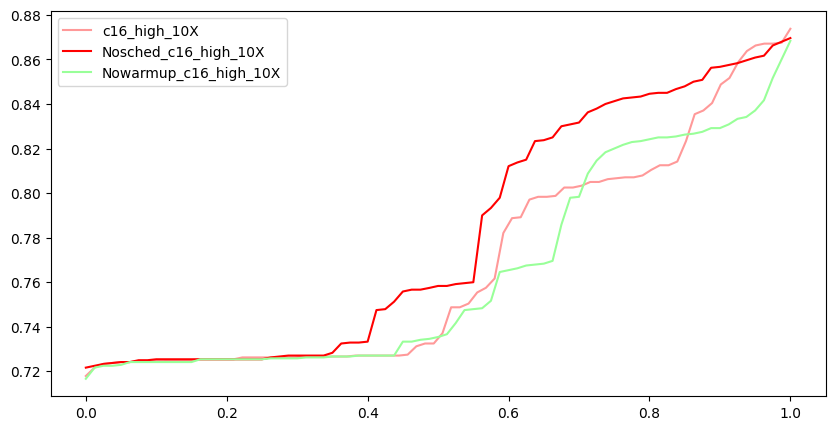

In [38]:
compare_features('avg best auc',[c16_high_10X,Nosched_c16_high_10X,Nowarmup_c16_high_10X],['c16_high_10X','Nosched_c16_high_10X','Nowarmup_c16_high_10X'],save='compare_sched_warmup_plot')

saved image


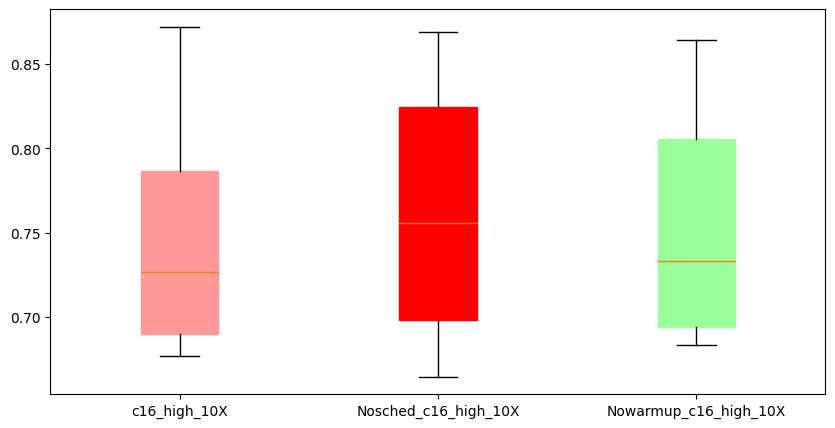

In [550]:
compare_features_box('avg_loss_auc',[c16_high_10X,Nosched_c16_high_10X,Nowarmup_c16_high_10X],['c16_high_10X','Nosched_c16_high_10X','Nowarmup_c16_high_10X'],figsize=(10,5),save='compare_sched_warmup_box')

# 对比classifier

In [43]:
from scipy import stats
def compare_classifier(df_list,name_list,figsize=(10,5),save=False):
    plt.figure(figsize=figsize)
    color_list = [
    "#007BFF", "#007BFF",  # 第一组：浅天蓝与亮蓝色  
    "#A5D6A7", "#A5D6A7",  # 第二组：浅玉绿与亮绿色 
    "#B10DC9", "#B10DC9",  # 第三组：浅紫色与亮紫色  
    "#FFA500", "#FFA500",  # 第四组：浅金色与亮橙色  
    "#00CED1", "#00CED1",  # 第五组：浅天蓝绿与亮蓝绿  |
    "#DC143C", "#DC143C",  # 第六组：浅玫瑰色与亮红色  
    "#00BFFF", "#00BFFF",  # 第七组：浅天蓝与亮青色  
    "#FF6347", "#FF6347",  # 第八组：浅玫瑰色与亮橙色  
#     "#ADD8E6", "#007BFF",  # 第一组：浅天蓝与亮蓝色  
#     "#C8E6C9", "#A5D6A7",  # 第二组：浅玉绿与亮绿色 
#     "#DDA0DD", "#B10DC9",  # 第三组：浅紫色与亮紫色  
#     "#FFD700", "#FFA500",  # 第四组：浅金色与亮橙色  
#     "#E6F7FA", "#00CED1",  # 第五组：浅天蓝绿与亮蓝绿  |
#     "#F08080", "#DC143C",  # 第六组：浅玫瑰色与亮红色  
#     "#87CEEB", "#00BFFF",  # 第七组：浅天蓝与亮青色  
#     "#FFDAB9", "#FF6347",  # 第八组：浅玫瑰色与亮橙色  
    ]  
    for i,(df,name,color,line) in enumerate(zip(df_list,name_list,color_list[:len(df_list)],['-','--']*8)):
        if i%2 == 0:
            Y_coords = np.sort(np.array(df['avg_loss_auc']))
        else:
            Y_coords = np.sort(np.array(df['val_auc']))
        X_coords = np.linspace(0, 1, len(Y_coords)) 
        print(f'{name} has {len(Y_coords)} data points')
        try:
            plt.plot(X_coords,Y_coords,label=name,color=color,linestyle=line)
        except Exception as e:
            print(f'{name} error:{e}')
    plt.legend()
    if save:
        plt.savefig(f'./model_selection/{save}.svg')
        print('saved image')
    plt.show()

        
def compare_classifier_med(stats,x_label,df_lists,name_list,save=False):
    #这里使用正负柱状图进行对比，故df_lists包含两个list，DSMIL和CLAM，name_list同样
    # stats:[mean, median]
    plt.figure(figsize=(15, 5))
    data = [[],[]]
    for i,(df_list,metrics) in enumerate(zip(df_lists,['avg_loss_auc','val_auc'])):
        print(metrics)
        for df in df_list:
            if stats == 'median':
                if np.isnan(df[metrics].median()):
                    data[i].append(0.5)
                else:
                    data[i].append(df[metrics].median())
            if stats == 'mean':
                if np.isnan(df[metrics].mean()):
                    data[i].append(0.5)
                else:
                    data[i].append(df[metrics].mean())
    print(data[0])
    plt.barh(name_list,np.array(data[0]),color=['#72B063'],height=0.3,label='DSMIL')
    plt.barh(name_list,-np.array(data[1]),color=['#EEB479'],height=0.3,label='CLAM')
    
    plt.xlim(-1,1)
    plt.xlabel(x_label)
    plt.ylabel('classifier extractor')
    plt.legend()
    if save:
        plt.savefig(f'./model_selection/{save}.svg')
        print('saved image')
    plt.show()

def compare_classifier_med_vertical(stats, x_label, df_lists, name_list, save=False):
    plt.figure(figsize=(10, 8))  # 调整为更合适的竖直排列图形尺寸
    data = [[], []]
    
    width = 0.35  # 条形图的宽度
    x = np.arange(len(name_list))  # 标签的位置
    
    for i, (df_list, metrics) in enumerate(zip(df_lists, ['avg_loss_auc', 'val_auc'])):
        print(metrics)
        for df in df_list:
            if stats == 'median':
                data[i].append(df[metrics].median() if not np.isnan(df[metrics].median()) else 0.5)
            if stats == 'mean':
                data[i].append(df[metrics].mean() if not np.isnan(df[metrics].mean()) else 0.5)

    plt.bar(x - width/2, data[0], width, color='#72B063', label='DSMIL')
    plt.bar(x + width/2, data[1], width, color='#EEB479', label='CLAM')

    plt.ylabel(x_label)
    plt.xlabel('Feature Extractor')
    plt.xticks(ticks=x, labels=name_list,rotation=45)  # 设置x轴刻度标签
    plt.ylim(0, 0.9)  # 设置y轴的限制
    plt.legend()

    if save:
        plt.savefig(f'./model_selection/{save}.svg')
        print('saved image')

    plt.show()
    
def t_test(df_lists,name_list,metrics_list=['avg_loss_auc','val_auc'],save=''):
    with open(f'./model_selection/{save}.txt','a+') as f:
        for index,(dsmil_df,clam_df) in enumerate(zip(df_lists[0],df_lists[1])):
            name = name_list[index]
            series1 = dsmil_df[metrics_list[0]]
            series2 = clam_df[metrics_list[1]]
            t_stat, p_value = stats.ttest_ind(series1, series2)
            f.write(f'{name}:t_stat:{t_stat},pvalue:{p_value}\n')

def anova(df_list,metric,save=''):
    with open(f'./model_selection/{save}.txt','a+') as f:
        t_stat, p_value = stats.f_oneway(*[i[metric] for i in df_list])
        f.write(f'anova_stat:{t_stat},pvalue:{p_value}\n') 
        
def Mann_Whitney_U(df_lists,name_list,metrics_list=['avg_loss_auc','val_auc'],save=''):
    with open(f'./model_selection/Mann_Whitney_U_{save}.txt','a+') as f:
        for index,(dsmil_df,clam_df) in enumerate(zip(df_lists[0],df_lists[1])):
                name = name_list[index]
                series1 = dsmil_df[metrics_list[0]]
                series2 = clam_df[metrics_list[1]]
                t_stat, p_value = stats.mannwhitneyu(series1, series2)
                f.write(f'{name}:MWU:{t_stat},pvalue:{p_value}\n')

def Kruskal_Wallis_H(df_list,metric,save=''):
    with open(f'./model_selection/KWH_{save}.txt','a+') as f:
        t_stat, p_value = stats.kruskal(*[i[metric] for i in df_list])
        f.write(f'KWH_stat:{t_stat},pvalue:{p_value}\n')   
            

In [29]:
CLAM_cTransPath = result_df[result_df['extractor'] == 'cTransPath_lr']
CLAM_PtRes18 = result_df[result_df['extractor'] == 'pretrained_resnet18']
CLAM_PtRes50 = result_df[result_df['extractor'] == 'pretrained_resnet50']
CLAM_c16 = result_df[result_df['extractor'] == 'c16_high']
CLAM_retccl = result_df[result_df['extractor'] == 'retccl_res50_2048']
CLAM_TCGA_high = result_df[result_df['extractor'] == 'TCGA_high']
CLAM_TCGA_low = result_df[result_df['extractor'] == 'TCGA_low']
CLAM_simclr = result_df[result_df['extractor'] == 'simclr_extracted_feats']

In [30]:
CLAM_cTransPath_10X = CLAM_cTransPath[CLAM_cTransPath['scale']=='10X']
CLAM_PtRes18_10X = CLAM_PtRes18[CLAM_PtRes18['scale']=='10X']
CLAM_PtRes50_10X = CLAM_PtRes50[CLAM_PtRes50['scale']=='10X']
CLAM_c16_10X = CLAM_c16[CLAM_c16['scale']=='10X']
CLAM_retccl_10X =CLAM_retccl[CLAM_retccl['scale']=='10X']
CLAM_TCGA_high_10X = CLAM_TCGA_high[CLAM_TCGA_high['scale']=='10X']
CLAM_TCGA_low_10X = CLAM_TCGA_low[CLAM_TCGA_low['scale']=='10X']
CLAM_simclr_10X = CLAM_simclr[CLAM_simclr['scale']=='10X']

In [31]:
CLAM_cTransPath_20X = CLAM_cTransPath[CLAM_cTransPath['scale']=='20X']
CLAM_PtRes18_20X = CLAM_PtRes18[CLAM_PtRes18['scale']=='20X']
CLAM_PtRes50_20X = CLAM_PtRes50[CLAM_PtRes50['scale']=='20X']
CLAM_c16_20X = CLAM_c16[CLAM_c16['scale']=='20X']
CLAM_retccl_20X = CLAM_retccl[CLAM_retccl['scale']=='20X']
CLAM_TCGA_high_20X = CLAM_TCGA_high[CLAM_TCGA_high['scale']=='20X']
CLAM_TCGA_low_20X = CLAM_TCGA_low[CLAM_TCGA_low['scale']=='20X']
CLAM_simclr_20X = CLAM_simclr[CLAM_simclr['scale']=='20X']

In [32]:
anova([CLAM_PtRes18_10X,CLAM_PtRes50_10X,CLAM_c16_10X,CLAM_cTransPath_10X,CLAM_retccl_10X,CLAM_TCGA_high_10X,CLAM_TCGA_low_10X,CLAM_simclr_10X],'val_auc',save='clam_fe_anova_10')
anova([CLAM_PtRes18_20X,CLAM_PtRes50_20X,CLAM_c16_20X,CLAM_cTransPath_20X,CLAM_retccl_20X,CLAM_TCGA_high_20X,CLAM_TCGA_low_20X,CLAM_simclr_20X],'val_auc',save='clam_fe_anova_20')


In [34]:
Kruskal_Wallis_H([CLAM_PtRes18_10X,CLAM_PtRes50_10X,CLAM_c16_10X,CLAM_cTransPath_10X,CLAM_retccl_10X,CLAM_TCGA_high_10X,CLAM_TCGA_low_10X,CLAM_simclr_10X],'val_auc',save='clam_fe_10')
Kruskal_Wallis_H([CLAM_PtRes18_20X,CLAM_PtRes50_20X,CLAM_c16_20X,CLAM_cTransPath_20X,CLAM_retccl_20X,CLAM_TCGA_high_20X,CLAM_TCGA_low_20X,CLAM_simclr_20X],'val_auc',save='clam_fe_20')

DSMIL_pretrained_resnet18 has 81 data points
CLAM_pretrained_resnet18 has 50 data points
DSMIL_pretrained_resnet50 has 81 data points
CLAM_pretrained_resnet50 has 50 data points
DSMIL_c16_high has 87 data points
CLAM_c16_high has 50 data points
DSMIL_cTransPath has 81 data points
CLAM_cTransPath has 30 data points
DSMIL_retccl has 81 data points
CLAM_retccl has 50 data points
DSMIL_TCGA_high has 81 data points
CLAM_TCGA_high has 50 data points
DSMIL_TCGA_low has 81 data points
CLAM_TCGA_low has 50 data points
DSMIL_simclr_scratch has 81 data points
CLAM_simclr_scratch has 30 data points
saved image


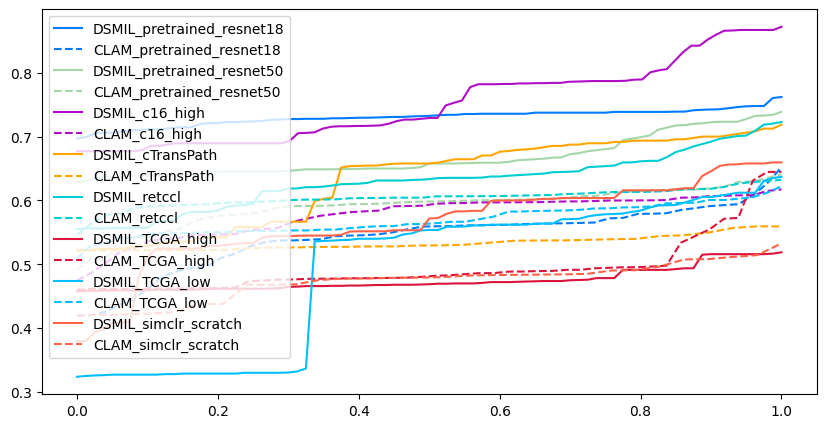

In [24]:
df_lists_line = [
    pretrained_resnet18_10X,CLAM_PtRes18_10X,pretrained_resnet50_10X,CLAM_PtRes50_10X,c16_high_10X,CLAM_c16_10X,cTransPath_10X,CLAM_cTransPath_10X,retccl_10X,CLAM_retccl_10X,TCGA_high_10X,CLAM_TCGA_high_10X,TCGA_low_10X,CLAM_TCGA_low_10X,simclr_10X,CLAM_simclr_10X
]
name_lists_line = [
    'DSMIL_pretrained_resnet18','CLAM_pretrained_resnet18','DSMIL_pretrained_resnet50','CLAM_pretrained_resnet50','DSMIL_c16_high','CLAM_c16_high','DSMIL_cTransPath','CLAM_cTransPath','DSMIL_retccl','CLAM_retccl','DSMIL_TCGA_high','CLAM_TCGA_high','DSMIL_TCGA_low','CLAM_TCGA_low','DSMIL_simclr_scratch','CLAM_simclr_scratch'
]
# compare_classifier(df_lists_line,name_lists_line)
compare_classifier(df_lists_line,name_lists_line,save='compare_classifier_line_10X')

avg_loss_auc
val_auc
[0.7303034979423868, 0.6672993827160494, 0.7511877394636014, 0.632150205761317, 0.6299948559670783, 0.47541152263374487, 0.4914917695473251, 0.5642179080004139]
saved image


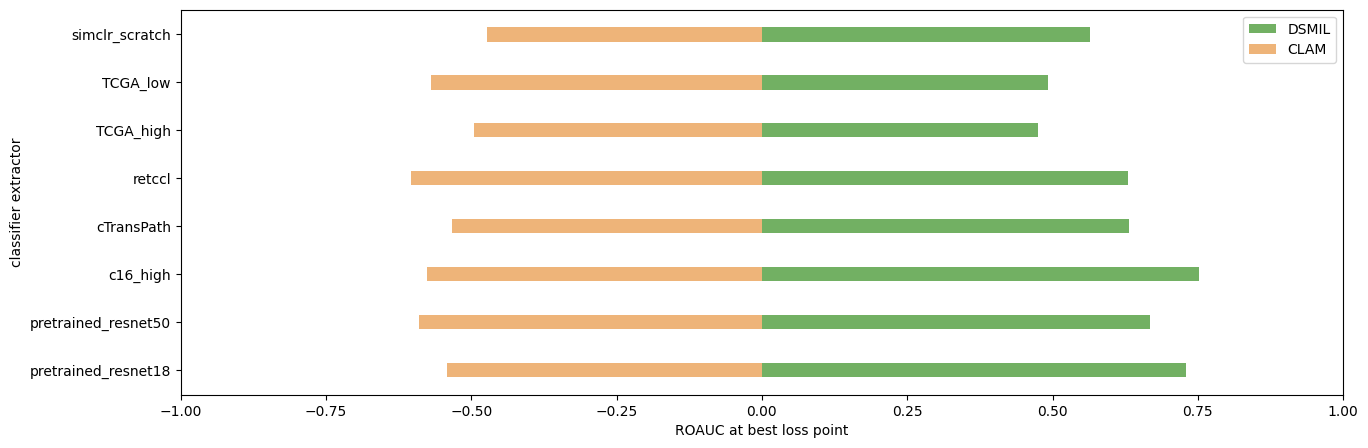

In [35]:
df_lists_med = [
    [pretrained_resnet18_10X,pretrained_resnet50_10X,c16_high_10X,cTransPath_10X,retccl_10X,TCGA_high_10X,TCGA_low_10X,simclr_10X],
    [CLAM_PtRes18_10X,CLAM_PtRes50_10X,CLAM_c16_10X,CLAM_cTransPath_10X,CLAM_retccl_10X,CLAM_TCGA_high_10X,CLAM_TCGA_low_10X,CLAM_simclr_10X]
]
name_lists_med = [
    'pretrained_resnet18','pretrained_resnet50','c16_high','cTransPath','retccl','TCGA_high','TCGA_low','simclr_scratch'
#     ['CLAM_pretrained_resnet18','CLAM_pretrained_resnet50','CLAM_c16_high','CLAM_cTransPath','CLAM_retccl','CLAM_TCGA_high','CLAM_TCGA_low','CLAM_simclr_scratch'] 
]
compare_classifier_med('mean','ROAUC at best loss point',df_lists_med,name_lists_med,save='compare_classifier_10X_mean')

avg_loss_auc
val_auc
saved image


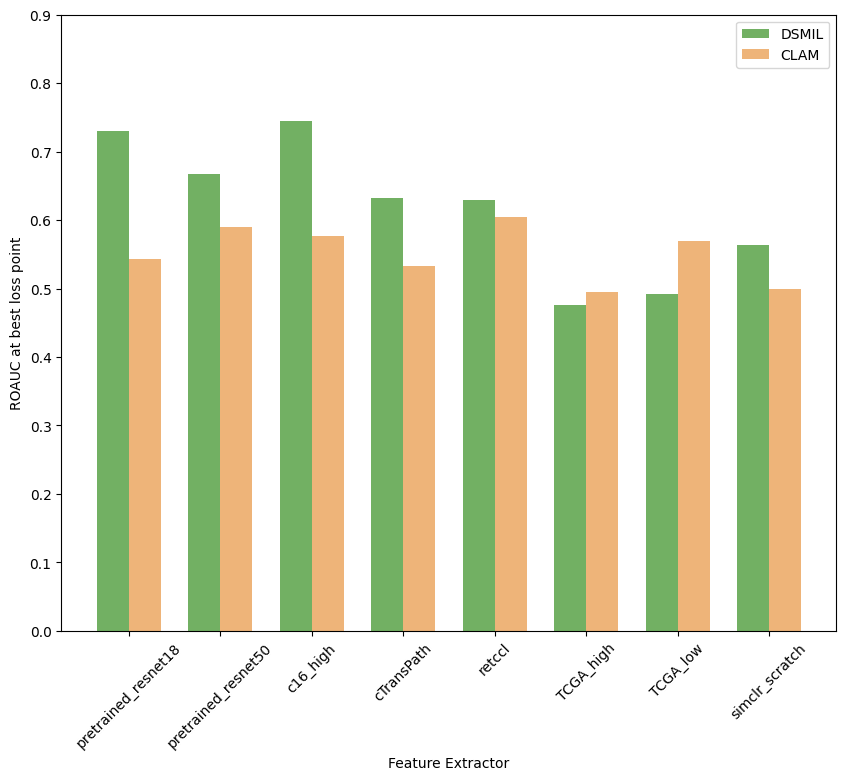

In [396]:
compare_classifier_med_vertical('mean','ROAUC at best loss point',df_lists_med,name_lists_med,save='compare_classifier_10X_mean_ver')

avg_loss_auc
val_auc
[0.7325, 0.6579166666666667, 0.7266666666666668, 0.6579166666666666, 0.6333333333333333, 0.46875, 0.55375, 0.5716666666666665]
saved image


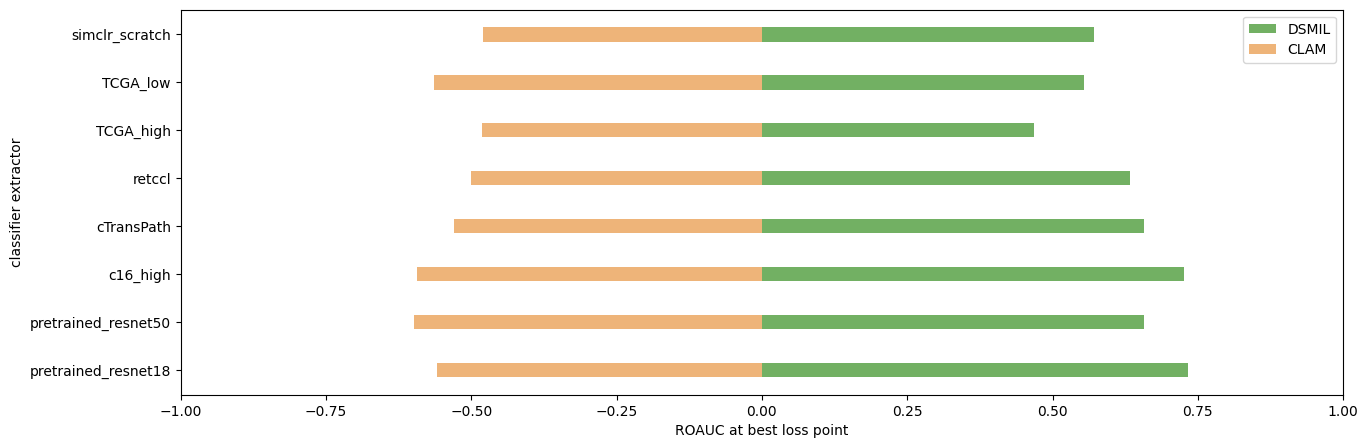

In [218]:
compare_classifier_med('median','ROAUC at best loss point',df_lists_med,name_lists_med,save='compare_classifier_10X_median')

avg_loss_auc
val_auc
saved image


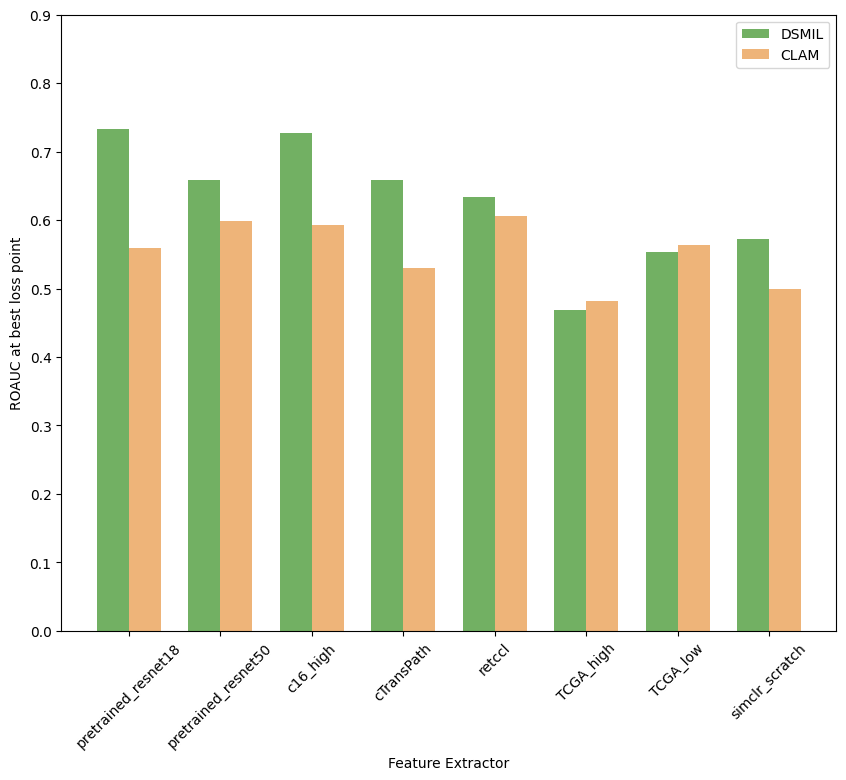

In [397]:
compare_classifier_med_vertical('median','ROAUC at best loss point',df_lists_med,name_lists_med,save='compare_classifier_10X_median_ver')

In [416]:
# t_test(df_lists_med,name_lists_med,save='10X_classifier_compare_ttest')
# t_test(df_lists_med_20,name_lists_med,save='20X_classifier_compare_ttest')

In [44]:
Mann_Whitney_U(df_lists_med,name_lists_med,save='10X_classifier_compare')
Mann_Whitney_U(df_lists_med_20,name_lists_med,save='20X_classifier_compare')

DSMIL_pretrained_resnet18 has 81 data points
CLAM_pretrained_resnet18 has 50 data points
DSMIL_pretrained_resnet50 has 81 data points
CLAM_pretrained_resnet50 has 47 data points
DSMIL_c16_high has 81 data points
CLAM_c16_high has 50 data points
DSMIL_cTransPath has 81 data points
CLAM_cTransPath has 30 data points
DSMIL_retccl has 79 data points
CLAM_retccl has 47 data points
DSMIL_TCGA_high has 81 data points
CLAM_TCGA_high has 50 data points
DSMIL_TCGA_low has 81 data points
CLAM_TCGA_low has 50 data points
DSMIL_simclr_scratch has 81 data points
CLAM_simclr_scratch has 30 data points
saved image


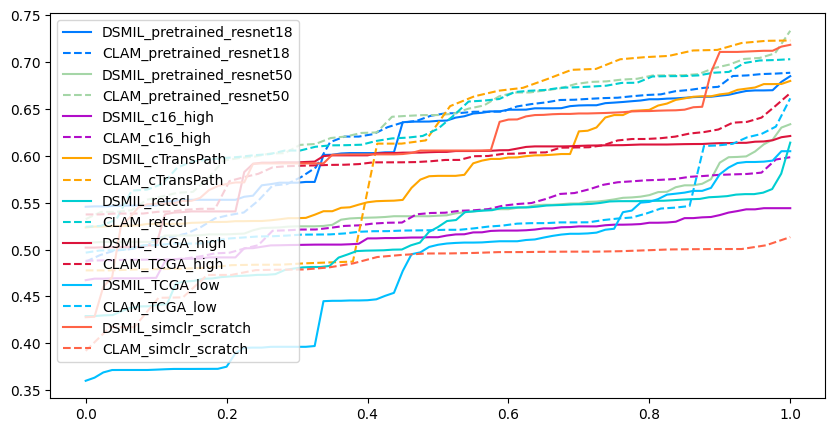

In [26]:
df_lists_line = [
    pretrained_resnet18_20X,CLAM_PtRes18_20X,pretrained_resnet50_20X,CLAM_PtRes50_20X,c16_high_20X,CLAM_c16_20X,cTransPath_20X,CLAM_cTransPath_20X,retccl_20X,CLAM_retccl_20X,TCGA_high_20X,CLAM_TCGA_high_20X,TCGA_low_20X,CLAM_TCGA_low_20X,simclr_20X,CLAM_simclr_20X]
name_lists_line = [
    'DSMIL_pretrained_resnet18','CLAM_pretrained_resnet18','DSMIL_pretrained_resnet50','CLAM_pretrained_resnet50','DSMIL_c16_high','CLAM_c16_high','DSMIL_cTransPath','CLAM_cTransPath','DSMIL_retccl','CLAM_retccl','DSMIL_TCGA_high','CLAM_TCGA_high','DSMIL_TCGA_low','CLAM_TCGA_low','DSMIL_simclr_scratch','CLAM_simclr_scratch'
]
# 
compare_classifier(df_lists_line,name_lists_line,save='compare_classifier_line_20X')

avg_loss_auc
val_auc
[0.615947685471495, 0.5429492200920772, 0.5117020545591974, 0.585201676630248, 0.5119062492661046, 0.5873547264023454, 0.47481023385785287, 0.6107675393389679]
saved image


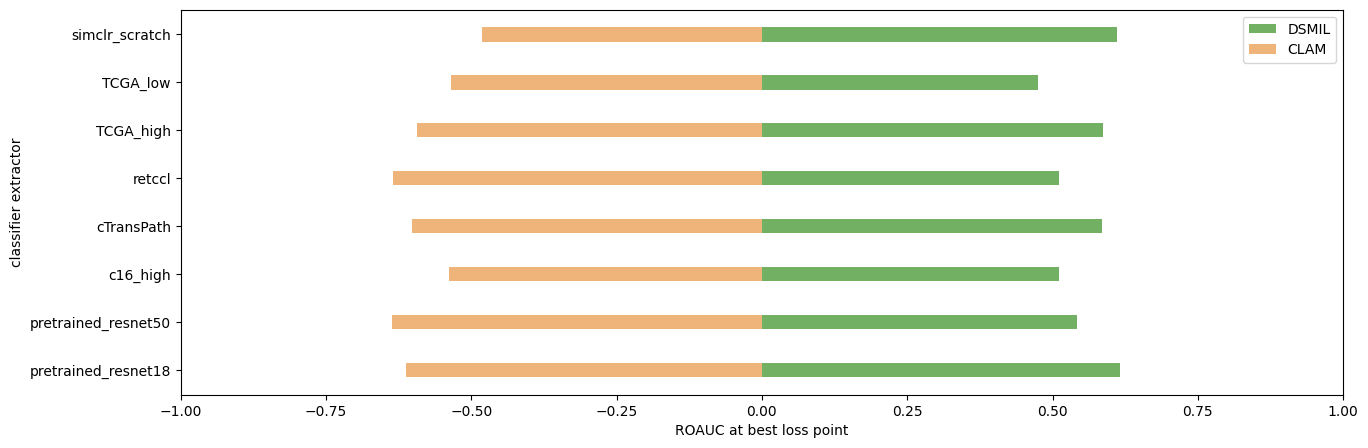

In [41]:
df_lists_med_20 = [
    [pretrained_resnet18_20X,pretrained_resnet50_20X,c16_high_20X,cTransPath_20X,retccl_20X,TCGA_high_20X,TCGA_low_20X,simclr_20X],
    [CLAM_PtRes18_20X,CLAM_PtRes50_20X,CLAM_c16_20X,CLAM_cTransPath_20X,CLAM_retccl_20X,CLAM_TCGA_high_20X,CLAM_TCGA_low_20X,CLAM_simclr_20X]
]
name_lists_med = [
    'pretrained_resnet18','pretrained_resnet50','c16_high','cTransPath','retccl','TCGA_high','TCGA_low','simclr_scratch'
#     ['CLAM_pretrained_resnet18','CLAM_pretrained_resnet50','CLAM_c16_high','CLAM_cTransPath','CLAM_retccl','CLAM_TCGA_high','CLAM_TCGA_low','CLAM_simclr_scratch'] 
]
compare_classifier_med('mean','ROAUC at best loss point',df_lists_med_20,name_lists_med,save='compare_classifier_20X_mean')

avg_loss_auc
val_auc
saved image


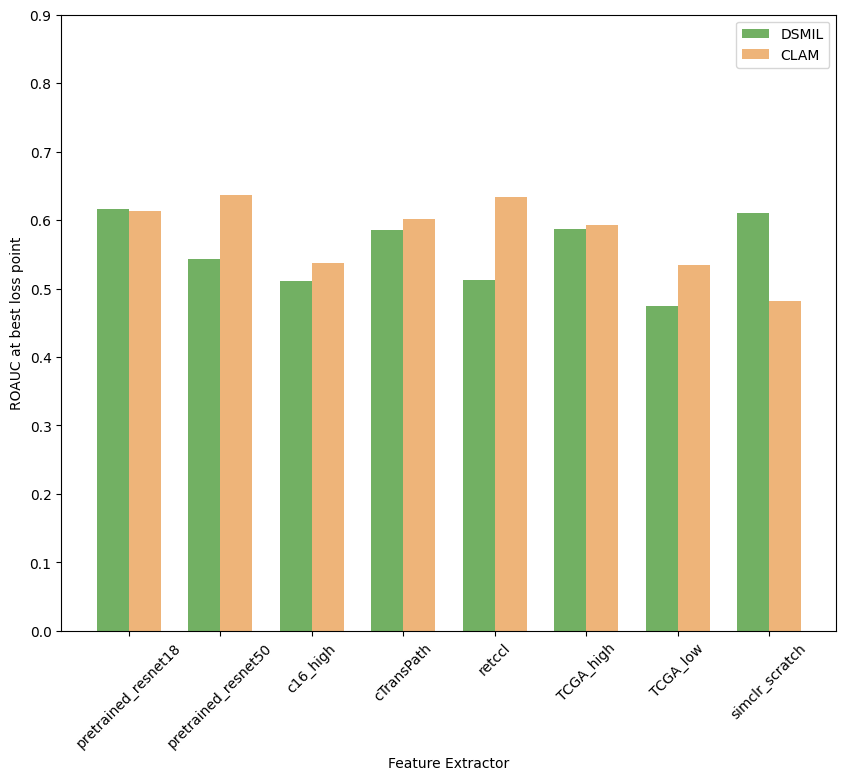

In [456]:
compare_classifier_med_vertical('mean','ROAUC at best loss point',df_lists_med_20,name_lists_med,save='compare_classifier_20X_mean_ver')

avg_loss_auc
val_auc
[0.6371799628942486, 0.5360667903525046, 0.5131354359925788, 0.5785528756957328, 0.5239703153988868, 0.6040445269016697, 0.5050834879406307, 0.6055287569573284]
saved image


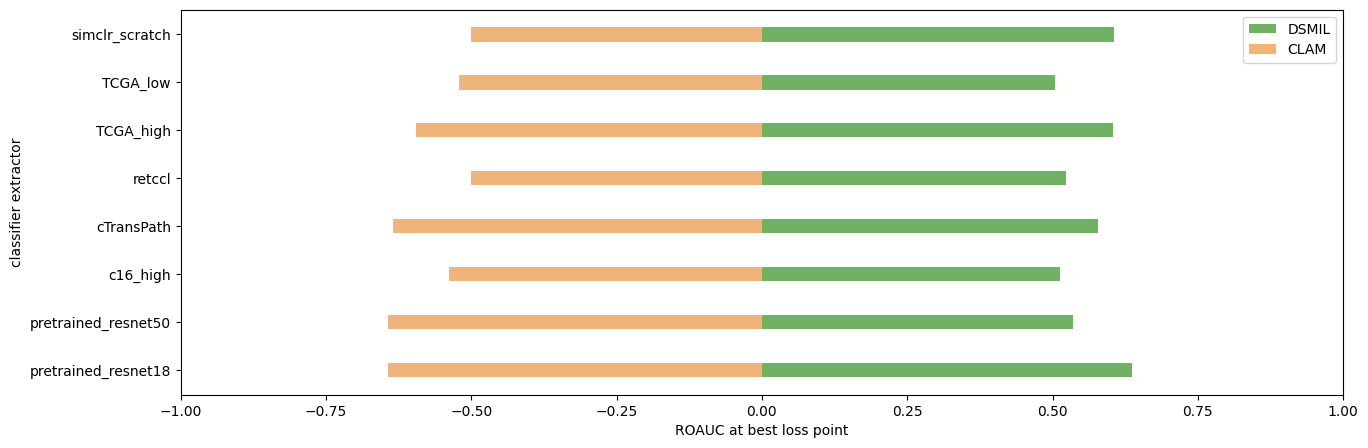

In [221]:
compare_classifier_med('median','ROAUC at best loss point',df_lists_med_20,name_lists_med,save='compare_classifier_20X_median')

avg_loss_auc
val_auc
saved image


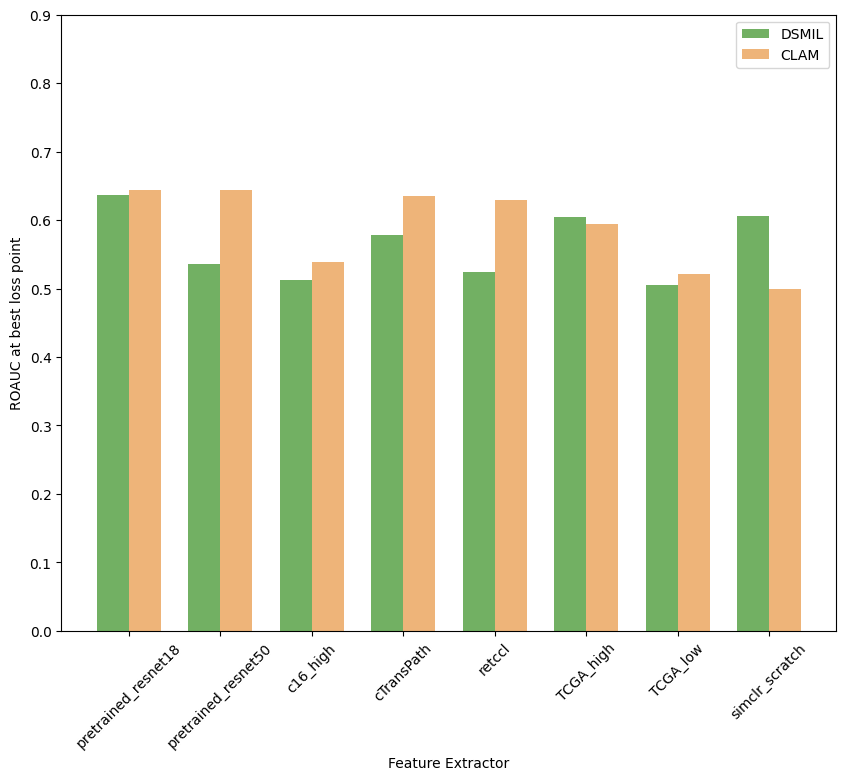

In [401]:
compare_classifier_med_vertical('median','ROAUC at best loss point',df_lists_med_20,name_lists_med,save='compare_classifier_20X_median_ver')

# 检查DSMIL acc

In [366]:
from tensorboard.backend.event_processing import event_accumulator
import os
from pathlib import Path
import pandas as pd
  
# 指定日志文件目录  

def find_events(description):
    logdir = "/GPUFS/sysu_jhluo_1/wangyh/data/TCGA_bladder_threshold_80/train/training_details"  
#     description = '10X_5fold_TCGA_high'

    # 获取所有事件文件   
    exp_folders = [f for f in os.listdir(os.path.join(logdir,description,'run'))] # 每个文件夹的名字
    event_list = []
    for exp in exp_folders:
        exp_folder_path = os.path.join(logdir,description,'run',exp)
        event_list.append(list(Path(exp_folder_path).rglob('event*')))
    return exp_folders,event_list
        
def event_parser(event):  
# 读取事件文件  
    if type(event) != str:
        event = str(event)
    ea = event_accumulator.EventAccumulator(event)  
    ea.Reload()  
  
    # 获取标量标签  
    keys = ea.scalars.Keys()
    df = pd.DataFrame(ea.scalars.Items('avg_score'))
    best_avg_score = df['value'].max()
    
    return best_avg_score
    
    # 打印所有标量值  
    
def get_exp_acc(events):
    acc = 0
    for event in events:
        acc += event_parser(event)
    
    avg_acc = acc / len(events)
    return avg_acc

def exp_set_parser(exp):
    _,lr,wd,Tmax,dropout_patch,dropout_node = exp.split('_')
    return lr,wd,Tmax,dropout_patch,dropout_node

def get_extractor_acc(description):
    try:
        exp_folders,event_list = find_events(description)
        acc_info = []
        save_path = os.path.join('/GPUFS/sysu_jhluo_1/wangyh/data/TCGA_bladder_threshold_80/train/training_details',description,'acc.csv')
        for exp,events in zip(exp_folders,event_list):
            try:
                avg_acc = get_exp_acc(events)
                learning_rate,weight_decay,Tmax,dropout_patch,dropout_node = exp_set_parser(exp)
                acc_info.append([learning_rate,weight_decay,Tmax,dropout_patch,dropout_node,avg_acc])
            except:
                pass
        df = pd.DataFrame(acc_info,columns=['learning_rate','weight_decay','Tmax','dropout_patch','dropout_node','avg_acc'])
        df.to_csv(save_path)
        print(f'{description} acc extraction finished')
    except Exception as e:
        print(f'{description} error :{e}')

In [377]:
def get_acc_from_file(description):
    path = os.path.join('/GPUFS/sysu_jhluo_1/wangyh/data/TCGA_bladder_threshold_80/train/training_details',description,'acc.csv')
    acc = pd.read_csv(path)['avg_acc']
    name = '_'.join(description.split('_')[2:])
    txt = f'{name}:mean{acc.mean()},sd{acc.std()},median{acc.median()},min:{acc.min()},max{acc.max()}\n'
    return txt

def get_auc_from_file(description):
    auc = reader_kfold(description)['avg_loss_auc']
    name = '_'.join(description.split('_')[2:])
    txt = f'{name}:mean{auc.mean()},sd{auc.std()},median{auc.median()},min:{auc.min()},max{auc.max()}\n'
    return txt

# finetune

In [564]:
c16_finetune1 = reader_kfold('10X_5fold_c16_high_finetune_1')
c16_finetune2 = reader_kfold('10X_5fold_c16_high_finetune_2')

In [599]:
show_topK_metrics(c16_finetune2,metrics='avg_loss_auc',k=30)

count    120.000000
mean       0.807858
std        0.053826
min        0.580000
25%        0.790729
50%        0.817083
75%        0.845521
max        0.872083
Name: avg_loss_auc, dtype: float64


,learning rate,weight_decay,Tmax,avg best score,avg best auc,best avg epoch,avg_loss_score,avg_loss_auc,avg_loss
34,0.000123,0.000041,75,1.302098,0.872917,57.6,1.277500,0.872083,0.392987
32,0.000123,0.000073,75,1.292737,0.878333,57.6,1.260165,0.868750,0.396062
70,0.000127,0.000083,75,1.291925,0.870833,57.6,1.267062,0.867500,0.397032
47,0.000124,0.000083,75,1.271825,0.865000,57.6,1.247227,0.864583,0.400269
111,0.000127,0.000041,75,1.286300,0.864583,57.6,1.262270,0.864167,0.393377
78,0.000106,0.000083,75,1.275158,0.864167,58.4,1.245977,0.863750,0.398218
29,0.000123,0.000004,75,1.224425,0.862500,57.6,1.200927,0.862083,0.400478
99,0.000127,0.000073,75,1.285050,0.865000,57.6,1.239705,0.862083,0.395613
84,0.000106,0.000041,75,1.270841,0.861667,58.4,1.239519,0.861667,0.401084
41,0.000297,0.000041,75,1.243290,0.870417,25.6,1.169569,0.860833,0.402489


In [566]:
def vis_lr_on_metrics_finetune(result, metrics, figsize=(40,20), save=False):
    result_df = result
    colors = []
    lr = result_df['learning rate']
    wd = result_df['weight_decay']

    # 初始化颜色映射和图例处理
    color_label_map = {
        'red': 'LR: 1e-4~1e-3',
        'blue': 'LR: 1e-3~1e-2',
        'green': 'LR: 1e-2~1e-1'
    }
    # 根据学习率值设定颜色
    for learning_rate in lr:
        if learning_rate >= 0.0001 and learning_rate < 0.001:
            colors.append('red')
        elif learning_rate >= 1e-3 and learning_rate < 1e-2:
            colors.append('blue')
        else:
            colors.append('green')

    # 绘制散点图
    plt.figure(figsize=figsize)
    scatter_plots = []
    for color in color_label_map:
        # 对每种颜色绘制一个空的散点图，用于图例
        scatter_plot = plt.scatter([], [], c=color, label=color_label_map[color])
        scatter_plots.append(scatter_plot)
    
    # 绘制实际的散点图，不包含label
    plt.scatter(wd, result[metrics], c=colors)
    
    # 添加图例
    plt.legend(handles=scatter_plots)

    plt.xlabel('Weight Decay')
    plt.ylabel(metrics)
    if save:
        plt.savefig(f'./model_selection/{save}.svg',format='svg')
        print('saved image')
    plt.show()


saved image


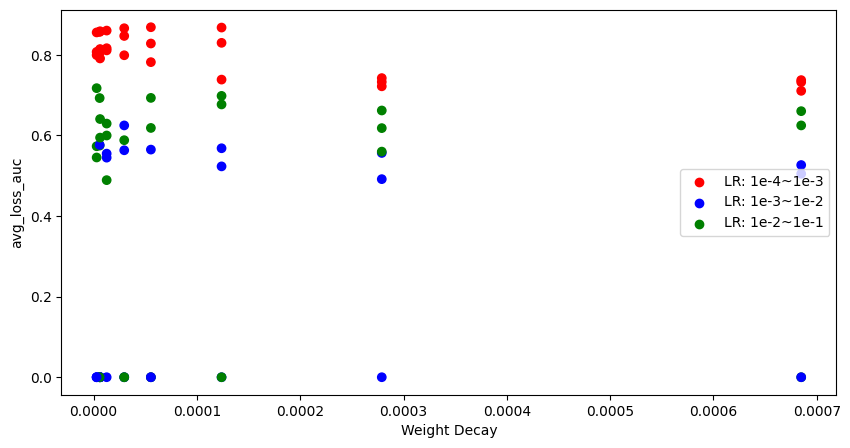

In [567]:
vis_lr_on_metrics_finetune(c16_finetune1,'avg_loss_auc',figsize=(10,5),save='compare_lr_expanded')

saved image


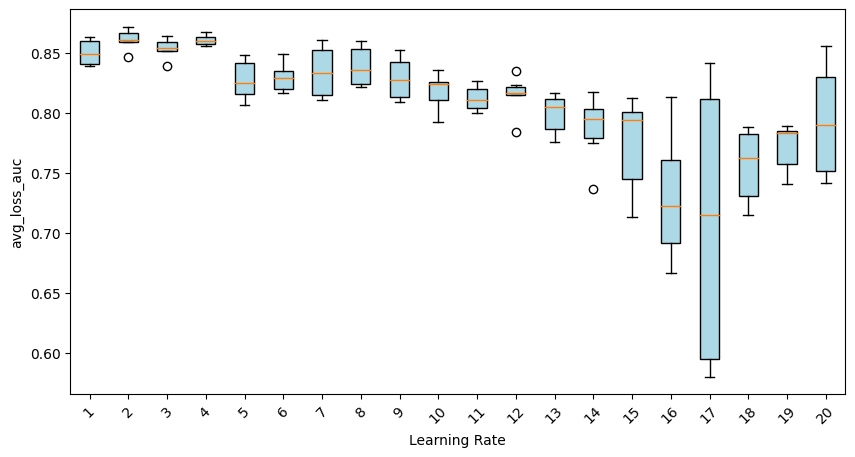

In [597]:
from matplotlib.ticker import ScalarFormatter
def vis_best_metrics(results, metrics, top=5, run=None, figsize=(10, 5), save=False):
    stats_df = results
    # 对学习率进行排序，并转换为科学计数法的字符串格式
    labels_lr = ["{:.2e}".format(i) for i in np.sort(stats_df["learning rate"].unique())]
    
    plt.figure(figsize=figsize)
    auc_list = []
    for lr in np.sort(stats_df["learning rate"].unique()):
        auc_list.append(stats_df[stats_df["learning rate"] == lr][metrics])
        
    box = plt.boxplot(auc_list, patch_artist=True)
    for patch in box['boxes']:
        patch.set_facecolor('lightblue')
        
    # 设置x轴刻度和标签
    plt.xticks(ticks=np.arange(1, len(labels_lr) + 1), labels=labels_lr, rotation=45)
    plt.xlabel("Learning Rate")
    plt.ylabel(metrics)
    
    # 使用科学计数法
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    plt.tick_params(axis='x', which='major', labelrotation=45)
    
    if save:
        plt.savefig(f'./model_selection/{save}.svg',format='svg')
        print('saved image')
        with open('finetune_lrs.txt','w') as f:
            f.write(str(labels_lr))
    plt.show()
    
vis_best_metrics(c16_finetune2,'avg_loss_auc',save='finetune_lr')